# Niagara Run Check
This notebook contains some easy scripts to .

In [1]:
import numpy as np, os, matplotlib.pyplot as plt
from peakpatchtools import PeakPatch
plt.rcParams['text.usetex'] = True

## Load Peak Patch runs

First things first, we define the Peak Patch simulation runs we're interested in and load them as a list of PeakPatch-class objects

In [2]:
# Peak Patch run directory (on the CITA network)
run_dir = '/scratch/r/rbond/nate/runs/'

# LIM runs
lim_dir = run_dir+'23.10.25_kpulse/'

# Runs varying m_lambda
m_lambda_dir = lim_dir+'z6/varying_ng8/'
run_dirs = [ lim_dir     +'z6/ng0/'      ,
             m_lambda_dir+'m_tach_10.0/' ,
             m_lambda_dir+'m_tach_15.0/' ,
             m_lambda_dir+'m_tach_20.0/' ,
             m_lambda_dir+'m_tach_25.0/' ,
             m_lambda_dir+'m_tach_30.0/' ,
             m_lambda_dir+'m_tach_35.0/' ,
             m_lambda_dir+'m_tach_40.0/' ] 

# Load Peak Patch runs as a list of PeakPatch objects
runs = []
for j in range(len(run_dirs)):
    runs += [ PeakPatch(run_dirs[j]) ]

I want to make a parametric fit to the $\mathcal{P}_{\chi\chi}(k)$ power spectrum. First things first, let's load the power spectra

In [4]:
# Load initial conditions power spectra
for j in range(1,len(runs)):
    runs[j].add_IC_power_spectra(spectrum_type='P_ping')

P_0 = P_00 e^(mu m_lambda)
P_00 =  5.915902208680933e-16
mu   =  0.38787487376330776

M = A ln(m_lambda) - B
A =  0.00481346161354462
B =  -0.004867566685439553


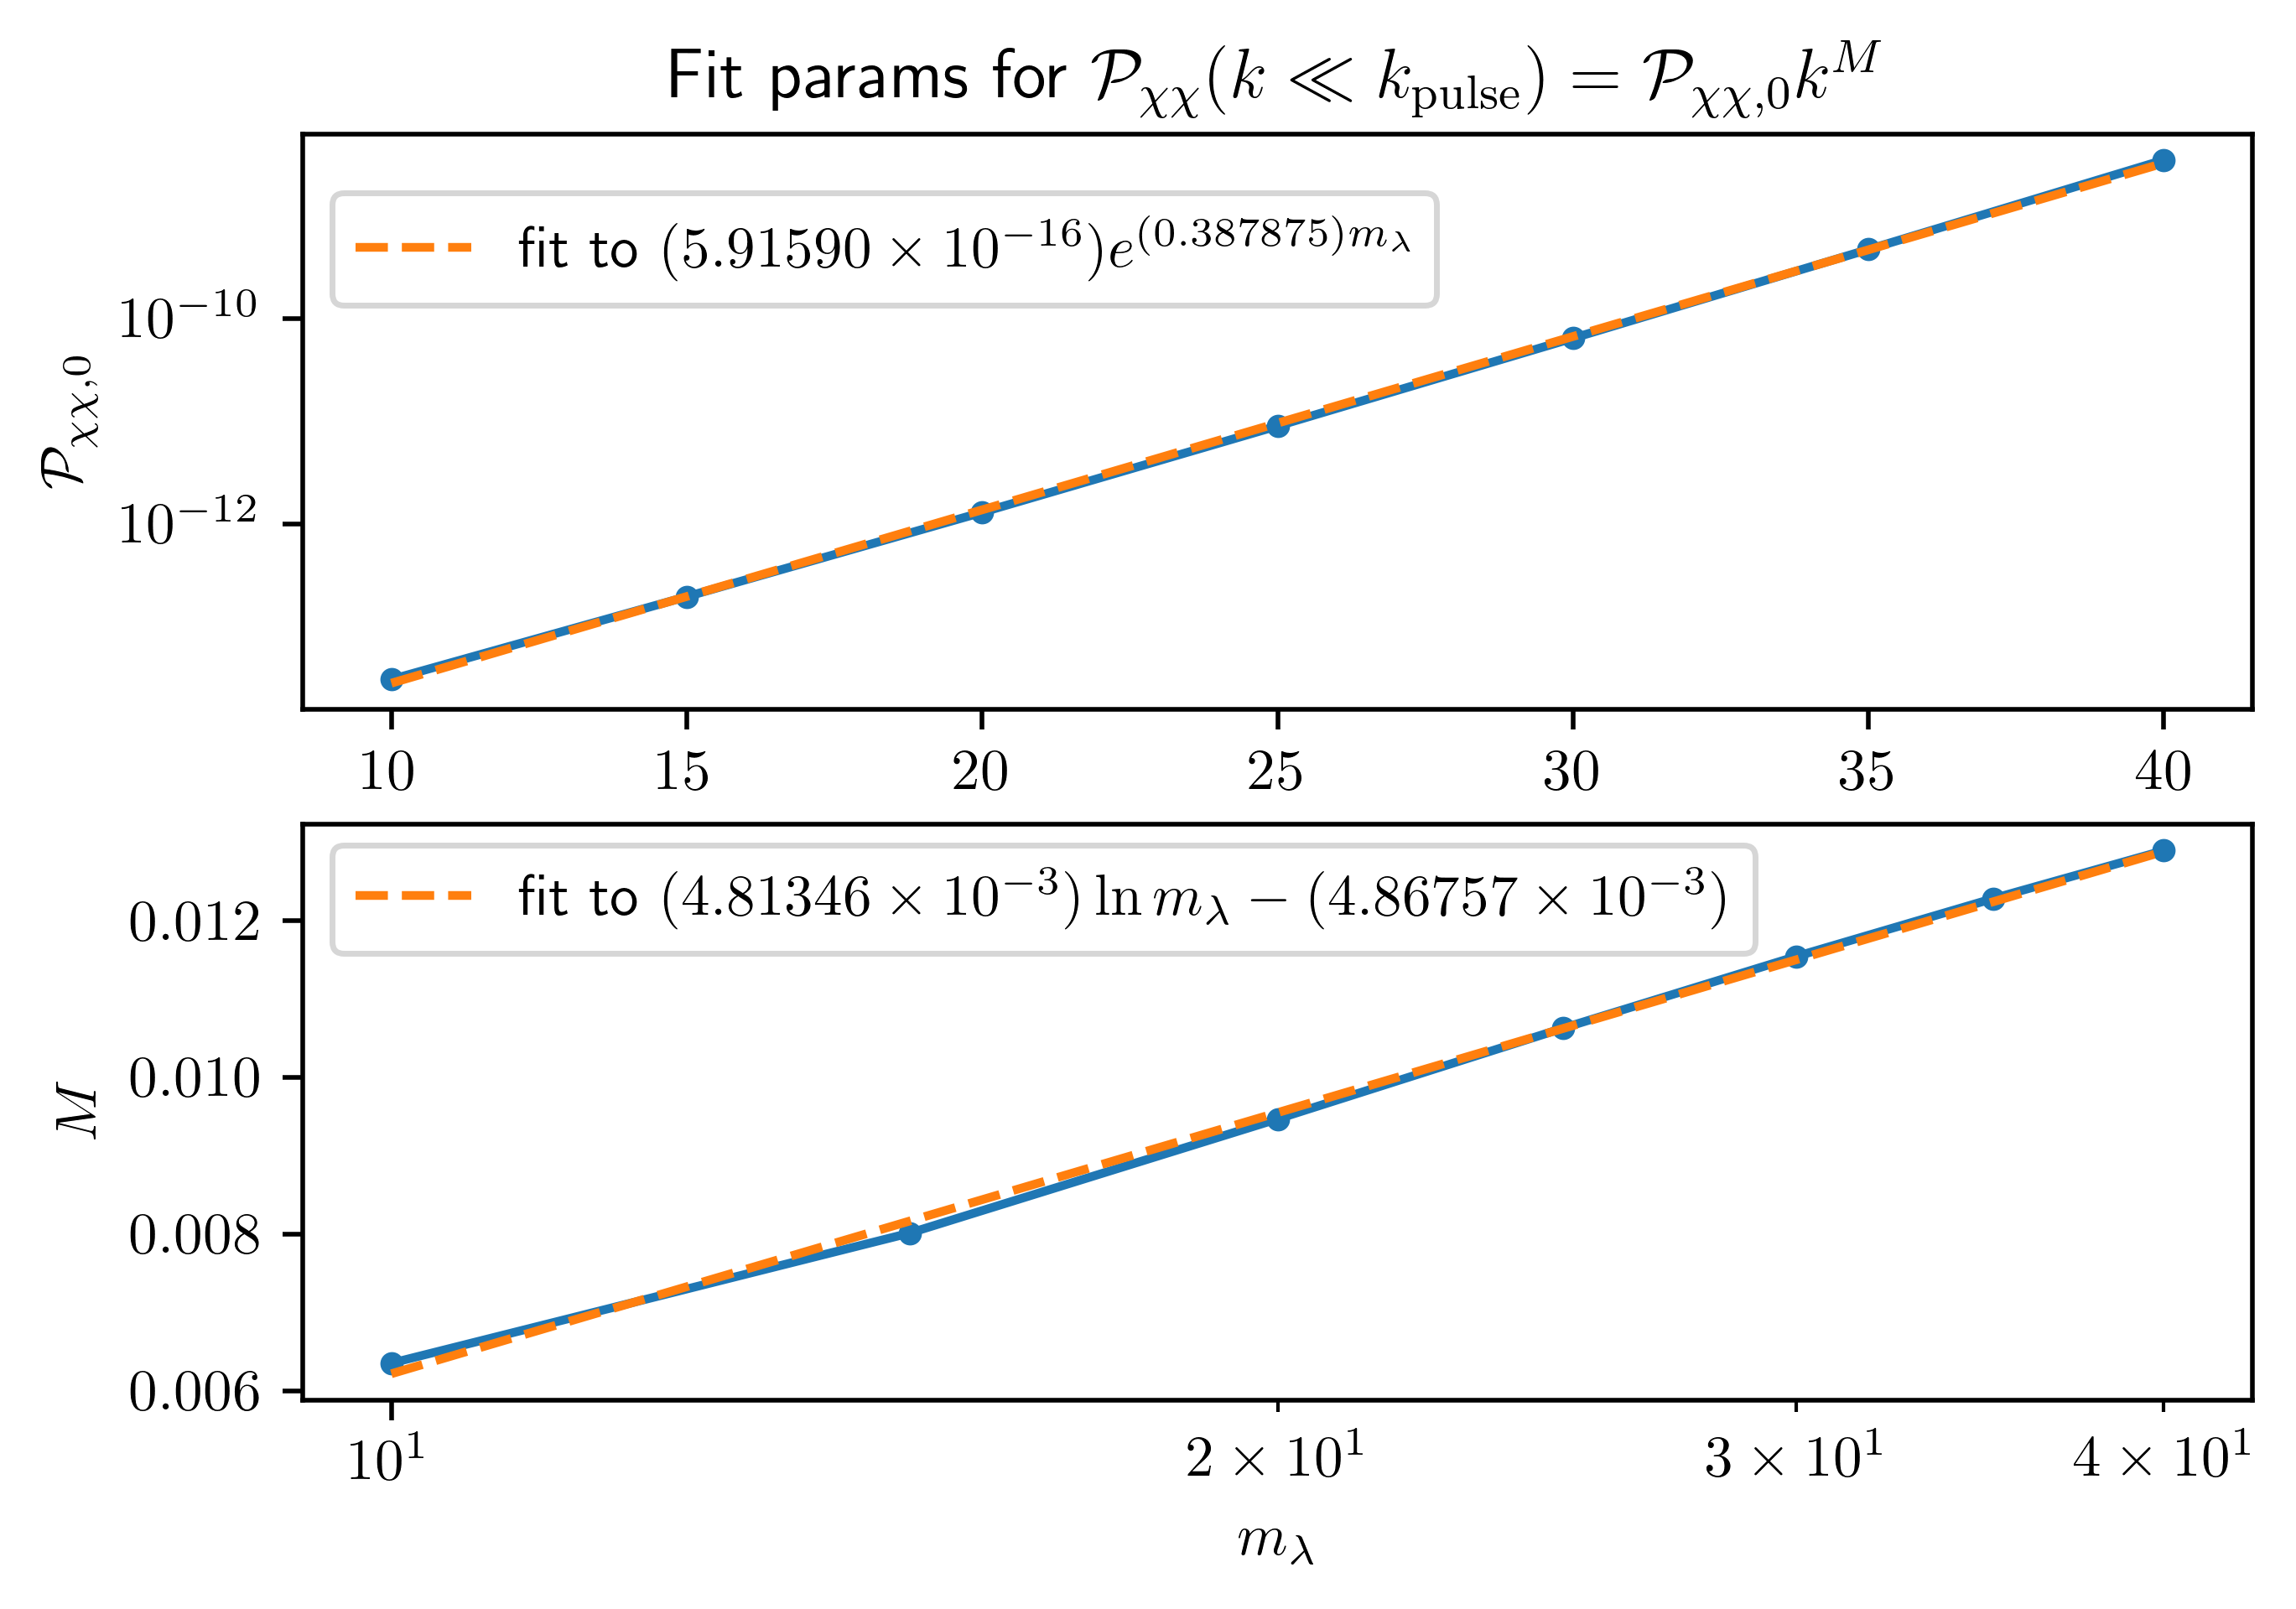

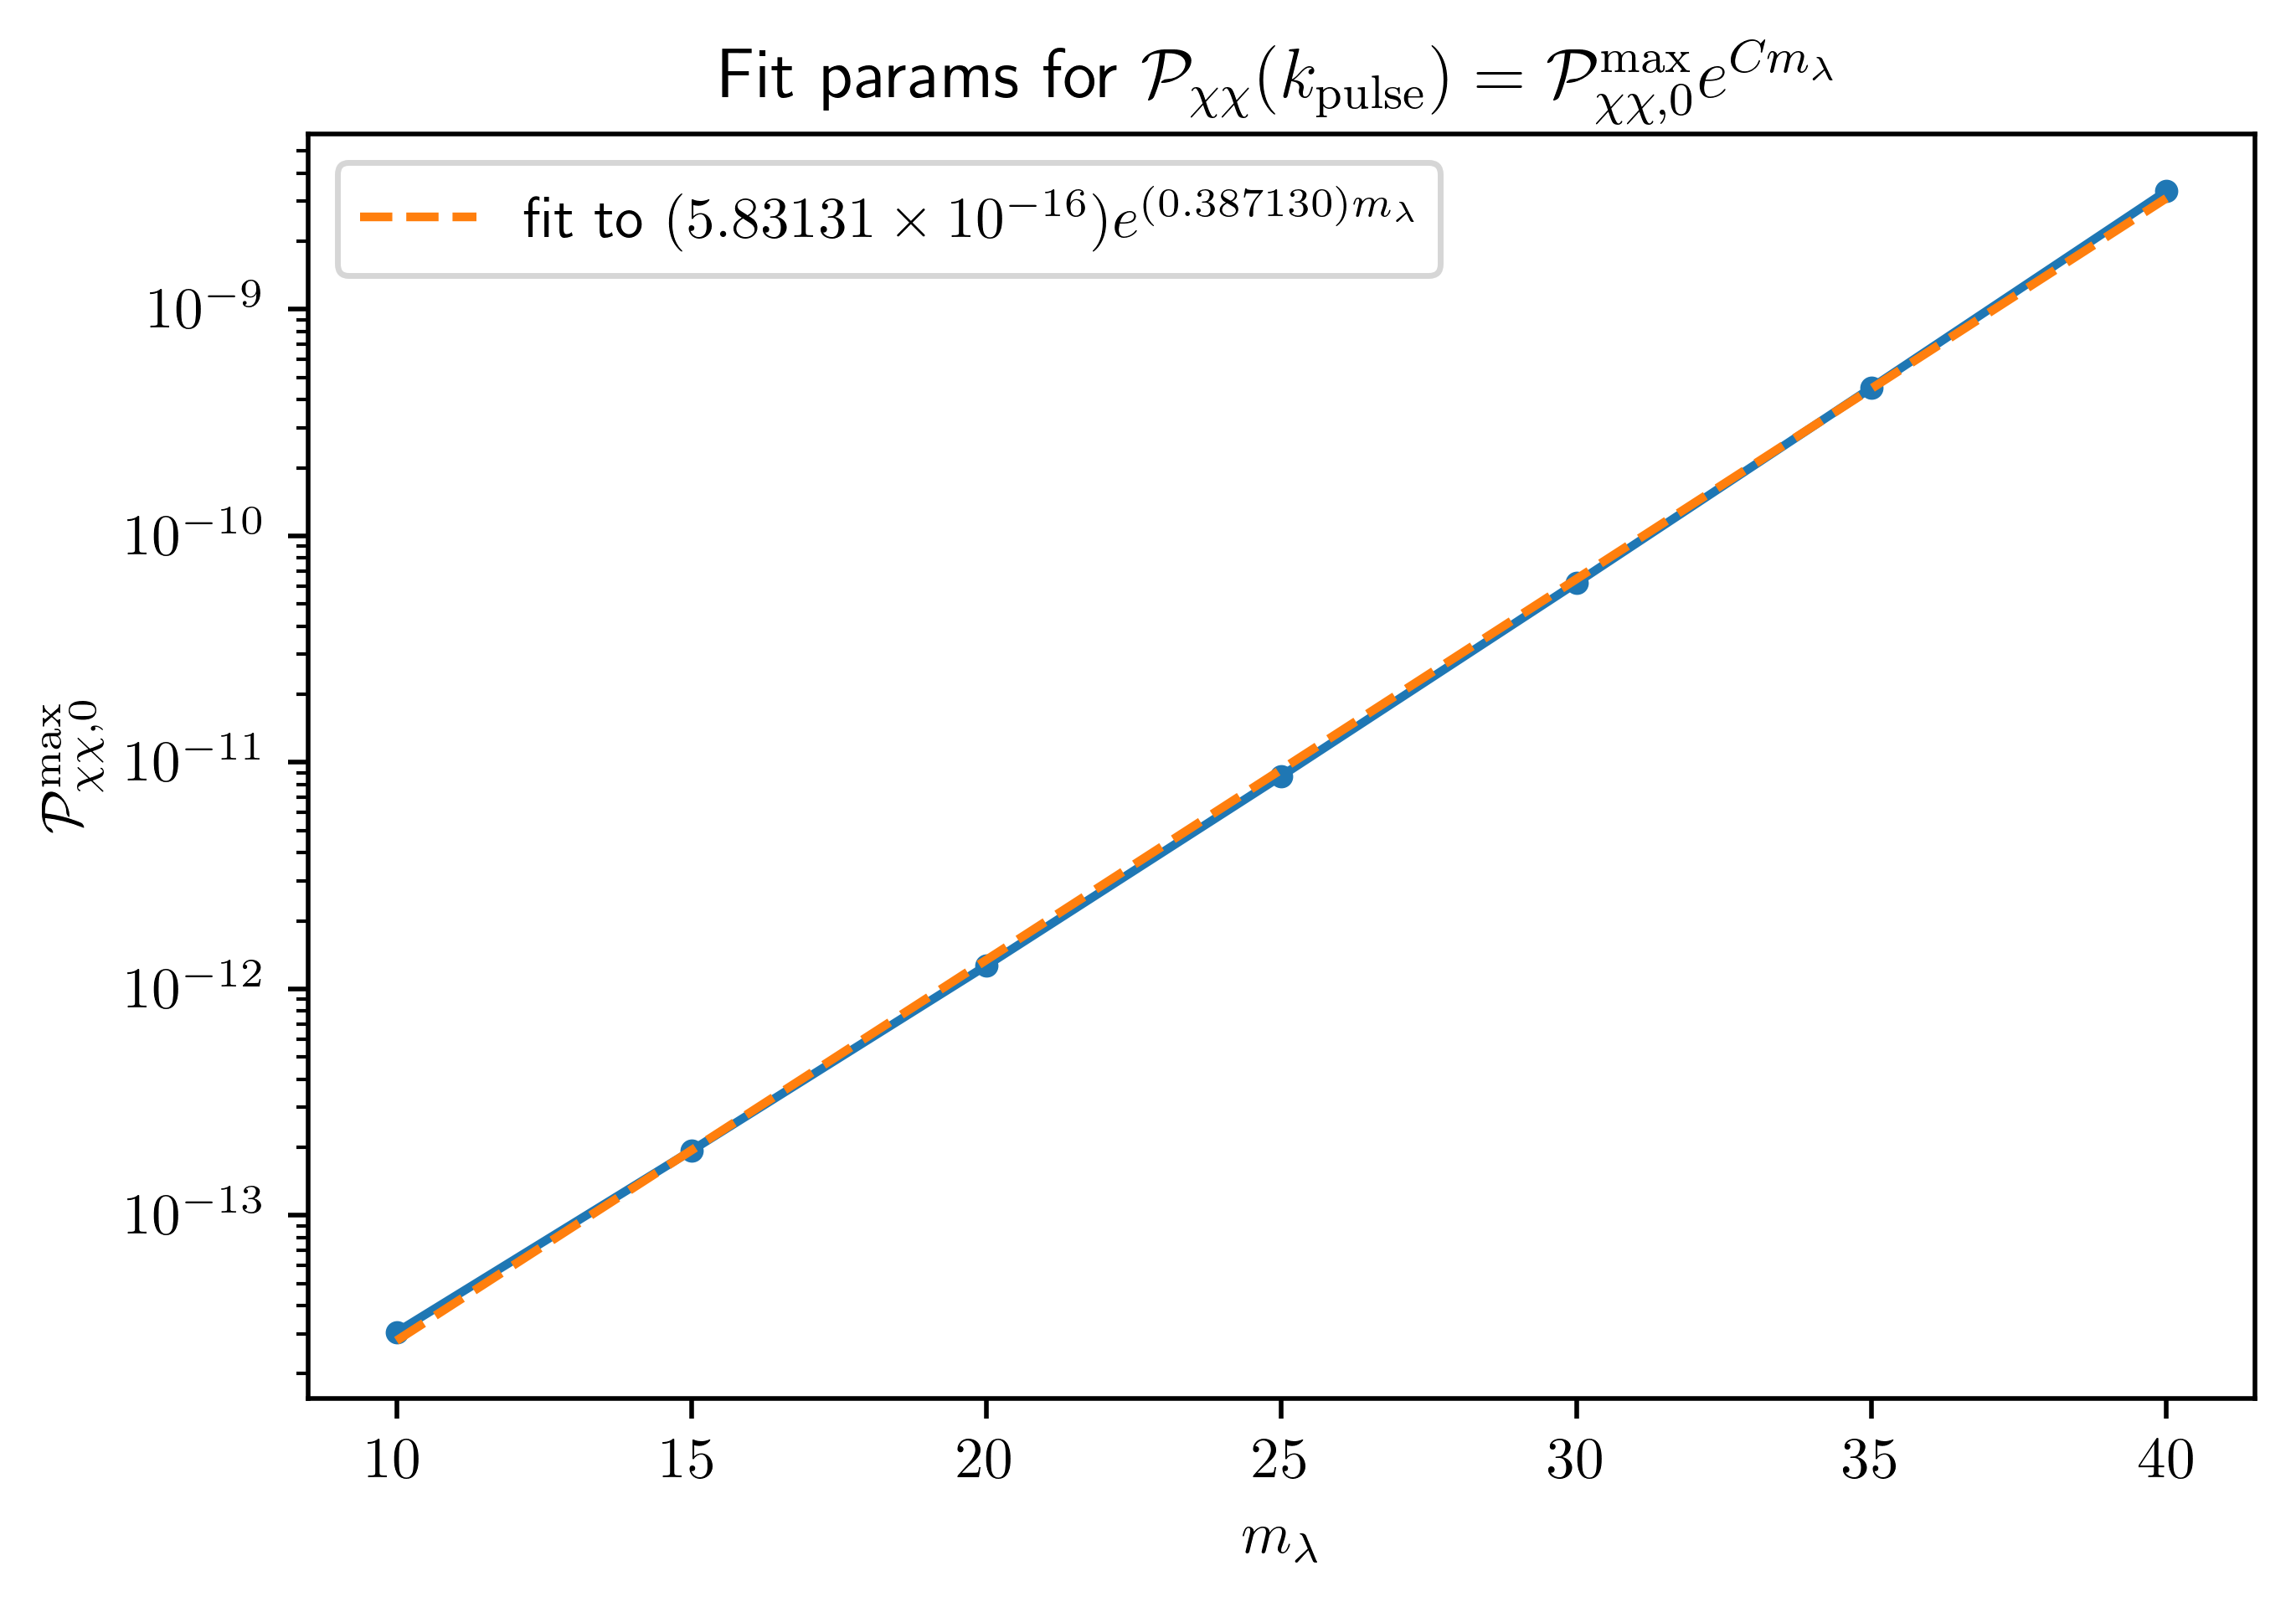

P_chichi(k_pulse) = P00max exp(C*m_lambda)
P00max =  5.831308132793251e-16
C      =  0.3871297624166462


In [140]:
from scipy.optimize import curve_fit

# # Define figure to compare power spectra
# fig,ax = plt.subplots( dpi=500, facecolor='white' )

jmin,jmax = 0,20

# Linear function for performing linear fits
def fit(x,m,b):
    return m*x+b

# Read chi power spectra and fit to linear function in log-log
M,P0,mlambda,Pmax = np.zeros((len(runs)-1)) , np.zeros((len(runs)-1)) , \
                    np.zeros((len(runs)-1)) , np.zeros((len(runs)-1))

for j in range(1,len(runs)):
    k = runs[j].k_ping[jmin:jmax]
    p = runs[j].p_chichi_ping[jmin:jmax]*runs[j].k_ping[jmin:jmax]**3/(2*np.pi**2)
    #ax.plot( k , p , 
    #         label=r'$\mathcal{{P}}_{{\chi\chi}}(k,m_\lambda={0})$'
    #        .format(runs[j].m_tach))
    
    # Fit ln(P) = m ln(k) + b
    lnk = np.log(k)
    lnp = np.log(p)
    popt   , pcov    = curve_fit( fit, lnk, lnp)
    M[j-1] , P0[j-1] = popt[0] , np.exp(popt[1])
    mlambda[j-1]     = runs[j].m_tach
    
    # Max value of P_chichi
    Pmax[j-1] = np.max(p)

# Plot the relationship between fit to P(k<kpulse) and m_lambda
fix,ax = plt.subplots(2, dpi=500)
ax[0].plot( mlambda , P0 , marker='.' )# , label=r'$\mathcal{P}_{\chi\chi,0}$' )
ax[1].plot( mlambda , M  , marker='.' )#, label=r'$M$' )

# Fit P_0 = P_00 e^{mu m_lambda}
popt, pcov = curve_fit( fit, mlambda, np.log(P0) )
mu  , P00  = popt[0] , np.exp(popt[1])

ax[0].plot( mlambda , P00*np.exp(mu*mlambda) , ls='--' ,
            label=r'fit to $({0:.5f}\times10^{{-16}})e^{{({1:.6f})m_\lambda}}$'
            .format( P00*1e16, mu )
          )

print( 'P_0 = P_00 e^(mu m_lambda)' )
print( 'P_00 = ',P00 )
print( 'mu   = ',mu  )

# Label and scale axes
ax[0].set_title(r'Fit params for $\mathcal{P}_{\chi\chi}(k \ll k_\mathrm{pulse}) = \mathcal{P}_{\chi\chi,0} k^M$')
#ax[0].set_xlabel(r'$m_\lambda$')
ax[0].set_ylabel(r'$\mathcal{P}_{\chi\chi,0}$')
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(0., 0.8))

# Fit M = ln(m_lambda)+b
popt, pcov = curve_fit( fit, np.log(mlambda), M )
A   , B    = popt[0] , popt[1]

ax[1].plot( mlambda , A*np.log(mlambda)+B , ls='--' ,
            label=r'fit to $({0:.5f}\times10^{{-3}})\ln m_\lambda - ({1:.5f}\times10^{{-3}})$'
            .format( A*1e3, -B*1e3 )
          )

ax[1].set_xlabel(r'$m_\lambda$')
ax[1].set_ylabel(r'$M$')
ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(0., 0.87))

print()
print( 'M = A ln(m_lambda) - B')
print( 'A = ',A )
print( 'B = ',B )

plt.show()

# fit max value of P_chichi(k)
fig2,ax2 = plt.subplots(1, dpi=500)

ax2.plot( mlambda, Pmax, marker='.' )

# Fit M = ln(m_lambda)+b
popt, pcov   = curve_fit( fit, mlambda, np.log(Pmax) )
C   , P00max = popt[0] , np.exp(popt[1])

ax2.plot( mlambda , P00max*np.exp(C*mlambda) , ls='--' ,
          label=r'fit to $({0:.5f}\times10^{{-16}})e^{{({1:.6f})m_\lambda}}$'
          .format( P00max*1e16, C )
        )

ax2.set_title(r'Fit params for $\mathcal{P}_{\chi\chi}(k_\mathrm{pulse}) = \mathcal{P}_{\chi\chi,0}^\mathrm{max} e^{{C m_\lambda}}$')
ax2.set_xlabel(r'$m_\lambda$')
ax2.set_ylabel(r'$\mathcal{P}_{\chi\chi,0}^\mathrm{max}$')
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(loc='best')#, bbox_to_anchor=(0., 0.87))

plt.show()

print( 'P_chichi(k_pulse) = P00max exp(C*m_lambda)' )
print( 'P00max = ',P00max )
print( 'C      = ',C )

Note that the values $\mathcal{P}_{\chi\chi,00}^\mathrm{max} \simeq \mathcal{P}_{\chi\chi,00}$ and $\mu \simeq C$, so we can see that we get a general trend

$$
\mathcal{P}_{\chi\chi}(k|m_\lambda) = 
$$

## Should maybe also be looking at value of $k_\mathrm{pulse}$ for the above variation of $m_\lambda$

Make copies of runs:

In [49]:
#bears = {}

'''
class Bears:
    def __init__(self,**kwargs):
        for key in kwargs:
            vars(self)[key] = kwargs[key]
            
bears = Bears(a=7,b=6)

print(bears.a)
print(bears.b)
'''

#bears['a'] = 3

#print(bears)

q = { 'a':6 , 'b':6 }

for key in q:
    print(key)


a
b


In [1]:
import numpy as np, os, matplotlib.pyplot as plt
from peakpatchtools import PeakPatch
plt.rcParams['text.usetex'] = True

base_run_dir = '/gpfs/fs0/scratch/r/rbond/nate/runs/23.10.25_kpulse/z6/varying_ng8/m_tach_25.0'

base_run = PeakPatch( base_run_dir )




In [2]:
copy_run = base_run.copy()
copy_run2= base_run.copy(vev=10)

{'vev': 10}


In [3]:
cr = PeakPatch(copy_run.run_dir)
cr2= PeakPatch(copy_run2.run_dir)

In [9]:
base_run.diff(copy_run2)

       |  m_tach_25.0  |  m_tach_25.0_2
-------+---------------+---------------
vev    |  0.1          |  10


{'vev': [0.1, 10]}

In [2]:
phi_w_values = np.array([ .7, .8, .9, 1.1, 1.2, 1.3 ]) * base_run.phi_w
phi_p_values = np.array([ .7, .8, .9, 1.1, 1.2, 1.3 ]) * base_run.phi_p
m_chi_values = np.array([ 1e1,1e2,1e3,1e4, 1e5, 1e6 ])
vev_values   = np.array([ .01, .05, .5, 1. ])
a_e_values   = np.array([ 9e-54, 9.5e-54, 9.75e-54, 1.25e-53, 1.5e-53, 2e-53 ])

for a in phi_w_values:
    os.system( 'rm -rf '+base_run_dir+'_phi_w_{0}'.format(a) )
    copy_run = base_run.copy( base_run_dir+'_phi_w_{0}'.format(a), phi_w=a )
    base_run.diff(copy_run)
        
for a in phi_p_values:
    os.system( 'rm -rf '+base_run_dir+'_phi_p_{0}'.format(a) )
    copy_run = base_run.copy( base_run_dir+'_phi_p_{0}'.format(a), phi_p=a )
    base_run.diff(copy_run)

for a in m_chi_values:
    os.system( 'rm -rf '+base_run_dir+'_m_chi_{0}'.format(a) )
    copy_run = base_run.copy( base_run_dir+'_m_chi_{0}'.format(a), m_chi=a )
    base_run.diff(copy_run)

for a in vev_values:
    os.system( 'rm -rf '+base_run_dir+'_vev_{0}'.format(a) )
    copy_run = base_run.copy( base_run_dir+'_vev_{0}'.format(a), vev=a )
    base_run.diff(copy_run)

for a in a_e_values:
    os.system( 'rm -rf '+base_run_dir+'_a_e_{0}'.format(a) )
    copy_run = base_run.copy( base_run_dir+'_a_e_{0}'.format(a), a_e=a )
    base_run.diff(copy_run)

    

       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.08782899999999999
-------+---------------+---------------------------------------
phi_w  |  0.12547      |  0.08782899999999999
       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.100376
-------+---------------+----------------------------
phi_w  |  0.12547      |  0.100376
       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.112923
-------+---------------+----------------------------
phi_w  |  0.12547      |  0.112923
       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.138017
-------+---------------+----------------------------
phi_w  |  0.12547      |  0.138017
       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.150564
-------+---------------+----------------------------
phi_w  |  0.12547      |  0.150564
       |  m_tach_25.0  |  m_tach_25.0_phi_w_0.163111
-------+---------------+----------------------------
phi_w  |  0.12547      |  0.163111
       |  m_tach_25.0  |  m_tach_25.0_phi_p_5.9496709999999995
-------+---------------+----------------------------------

In [3]:
#thing = PeakPatch(base_run_dir+'_a_e_9e-54')
#base_run.diff(thing)


AttributeError: 'PeakPatch' object has no attribute 'next'

In [11]:
copied_run = PeakPatch( base_run_dir+'_1' )

base_run.diff( copied_run )

'Identical parameter files'

In [13]:
directory = '/scratch/r/rbond/nate/'
file      = 'junk.junk'

os.system( 'touch {0}{1}'.format(directory,file) )

print( 'touch {0}{1}'.format(directory,file) )

os.system( 'echo "bears" > {0}{1}'.format(directory,file) )

touch /scratch/r/rbond/nate/junk.junk


0

In [8]:
print( base_run.a_e )
print( thing.a_e    )

thing.edit( a_e = 7 )

print(thing.a_e)

print( thing.run_dir
     )


1e-53
7
7
/gpfs/fs0/scratch/r/rbond/nate/runs/23.10.25_kpulse/z6/varying_ng8/m_tach_25.0_a_e_9e-54


In [8]:
def thing(**kwargs):
    for key in kwargs:
        print( 'kwargs[{0}] = {1}'.format(key, kwargs[key]))
        
thing(bears='mammals', bats='birds')

stuff = {'bears':'mammals' , 'bats':'birds'}

thing(**stuff)

print( kwargs )

kwargs[bears] = mammals
kwargs[bats] = birds
kwargs[bears] = mammals
kwargs[bats] = birds


In [8]:
# base_run.a_e = 1e-53
# print( base_run.a_e           )

base_run.edit(a_e = 1e-53)

base_run.a_e




AttributeError: 'dict' object has no attribute 'key'

In [179]:
thing.params['compile_hpkvd']

0

In [9]:
vars( base_run )

{'params': {'hpkvd_params': 1,
  'compile_hpkvd': 1,
  'create_filterbank': 1,
  'merge_params': 1,
  'compile_merge': 1,
  'map_params': 1,
  'compile_maps': 1,
  'batch': 1,
  'submit': 0,
  'machine': 'niagara',
  'submit_command': 'sbatch',
  'seed': 13579,
  'run_name': '500Mpc_n432_nb74_nt3',
  'short_name': '500Mpc_nb74',
  'runtype': 'single',
  'boxsize': 500.0,
  'nmesh': 432,
  'nbuff': 74,
  'ntile': 3,
  'largerun': 0,
  'tlimit': '01:00:00',
  'nnodes': 1,
  'tpnode': 20,
  'ntasks': 20,
  'ncpus': 1,
  'nompth': 1,
  'tlimit_map': '24:00:00',
  'nnodes_map': 1,
  'ppn_map': 1,
  'ntasks_map': 1,
  'np_map': 40,
  'nompth_map': 1,
  'ievol': 1,
  'num_redshifts': 1,
  'maximum_redshift': 1100.0,
  'global_redshift': 0.0,
  'ilpt': 2,
  'ioutfield': 1,
  'ireadfield': 0,
  'iwant_field_part': 0,
  'fielddir': 'fields/',
  'densfilein': '500Mpc_n432_nb74_nt3',
  'densfileout': '500Mpc_n432_nb74_nt3',
  'NonGauss': 8,
  'fNL': 0.0,
  'A_nG': 0.0,
  'B_nG': 0.0,
  'R_nG': 0.0

In [13]:
vars(base_run)['a_e'] = 1e-53
base_run.a_e

1e-53

Next we read in the initial conditions power spectra and fields along with the final dark matter halo catalouges for each of the Peak Patch runs

In [3]:
# Load initial conditions power spectra
for j in range(len(runs)):
    runs[j].add_IC_power_spectra(spectrum_type='P_deltadelta')
    runs[j].add_IC_power_spectra(spectrum_type='P_zetazeta')
    runs[j].add_IC_power_spectra(spectrum_type='T_zeta2delta')
    if j>0:
        runs[j].add_IC_power_spectra(spectrum_type='P_ping')

In [4]:
# Calculate power spectra from field files
runs[0].get_power_spectrum(field_type='rhog')
runs[1].get_power_spectrum(field_type='zetag')

for j in range(len(runs)):
    runs[j].get_power_spectrum(field_type='rho')
    runs[j].get_power_spectrum(field_type='zeta')

It appears that a power spectrum has already been read from this field:
/mnt/scratch-lustre/njcarlson/peak-patch-runs/23.10.25_kpulse/z6/ng0/tables/p_rhog_500Mpc_n432_nb74_nt3
This spectrum will be used. To measure the power spectrum again and overwrite the existing file, run
this function again with argument overwrite=True.
It appears that a power spectrum has already been read from this field:
/mnt/scratch-lustre/njcarlson/peak-patch-runs/23.10.25_kpulse/z6/varying_ng8/m_tach_10.0/tables/p_zetag_500Mpc_n432_nb74_nt3
This spectrum will be used. To measure the power spectrum again and overwrite the existing file, run
this function again with argument overwrite=True.
It appears that a power spectrum has already been read from this field:
/mnt/scratch-lustre/njcarlson/peak-patch-runs/23.10.25_kpulse/z6/ng0/tables/p_rho_500Mpc_n432_nb74_nt3
This spectrum will be used. To measure the power spectrum again and overwrite the existing file, run
this function again with argument overwrite=True.

In [ ]:
# Load chi field slices
for j in range(len(runs)):
    runs[j].add_field_slice(field_type='rho')
    runs[j].add_field_slice(field_type='zeta')
    if j>0:
        runs[j].add_field_slice(field_type='rhog')
        runs[j].add_field_slice(field_type='zetag')
        runs[j].add_field_slice(field_type='chi')

In [10]:
# number of runs with halos
N_runs_w_halos = 6

# Load halos
for j in range( N_runs_w_halos ):
    runs[j].add_halos()

## Plotting and post-processing

Now that we've read all the data we need into python, we can proceed with our analysis.

### Power spectra (initial conditions)
I'll start this with a cell that makes a plot of the power spectra from which we construct our initial conditions.

\begin{align}
    \mathcal{P}_{\xi\xi}(k) = \frac{k^3}{2\pi^2} \langle | \tilde{\xi} |^2 \rangle
\end{align}

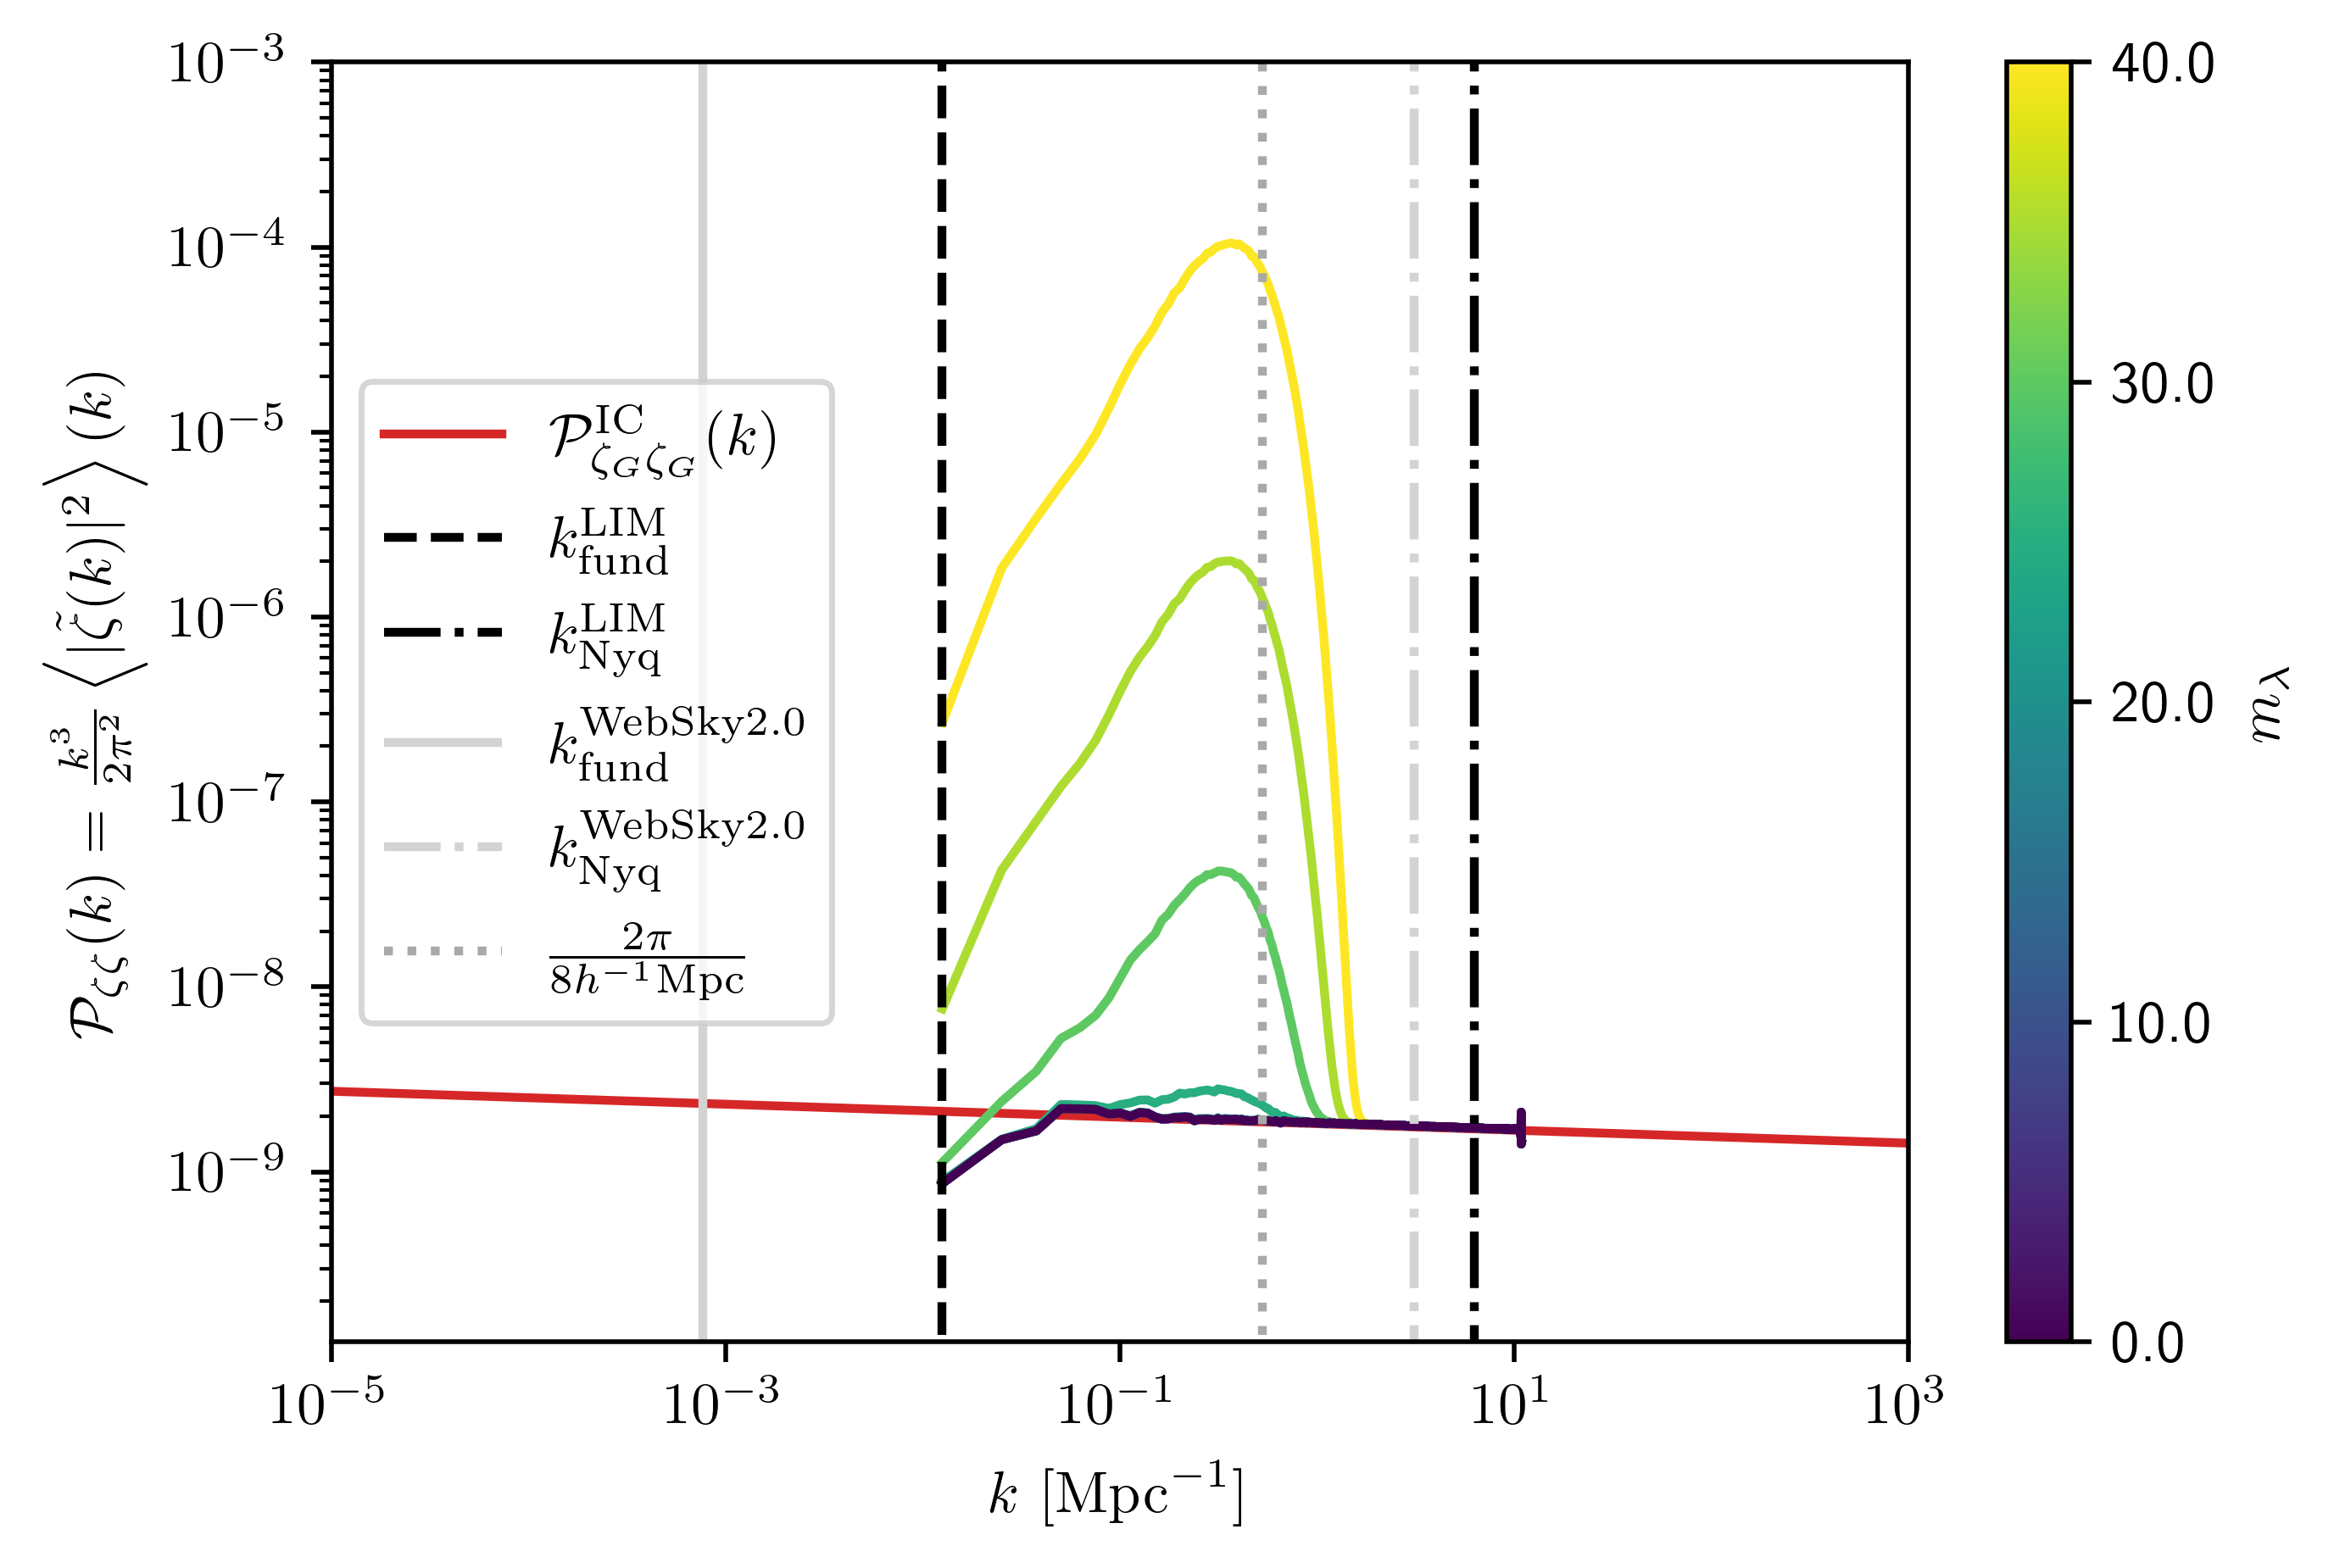

In [22]:
# Define figure to compare power spectra
fig,ax = plt.subplots( dpi=500, facecolor='white' )

# Plot zeta_G power spectrum
ax.plot( runs[0].k_zetazeta , runs[0].k_zetazeta**3*runs[0].P_zetazeta/(2*np.pi**2) ,
         label=r'$\mathcal{P}_{\zeta_G\zeta_G}^\mathrm{IC}(k)$',
         c='tab:red' )

# Get adjustment
Pzeta0 = ( np.mean( runs[0].k_zetazeta[625:685]**3*runs[0].P_zetazeta[625:685]/(2*np.pi**2) ) /
           np.mean( runs[1].p_from_zetag[130:-10]*runs[1].k_from_zetag[130:-10]**3/(2*np.pi**2) ) )

# Plot zeta calculated form files
for j in range(len(runs)-1,0,-1):
    ax.plot( runs[j].k_from_zeta, Pzeta0 * runs[j].p_from_zeta * runs[j].k_from_zeta**3/(2*np.pi**2) ,
             #label=r'$\mathcal{{P}}_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
             c = plt.cm.viridis( runs[j].m_tach/runs[-1].m_tach )
           )

# Plot zetag calculated from file
ax.plot( runs[1].k_from_zetag, Pzeta0 * runs[1].p_from_zetag * runs[1].k_from_zetag**3/(2*np.pi**2) ,
         #label=r'$\mathcal{P}_{\zeta\zeta}$ from file')
         c = plt.cm.viridis( 0.0 ) )
    
# Make colour bar to show m_lambda range
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label=r'$m_\lambda$')
cbar.set_ticks(np.linspace(0, 1., 5))
cbar.set_ticklabels(np.linspace(0, runs[-1].m_tach, 5))

# Vertical lines at fundamental and Nyquist wavenumbers for LIM runs
p_min = np.min(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
p_max = np.max(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
ax.vlines( runs[0].kfund, p_min, p_max, label=r'$k_\mathrm{fund}^\mathrm{LIM}$', color='k', ls='--' )   
ax.vlines( runs[0].knyq , p_min, p_max, label=r'$k_\mathrm{Nyq}^\mathrm{LIM}$'    , color='k', ls='-.' )    

# Vertical lines at fundamental and Nyquist wavenumbers for WebSky2.0
kfund_WS2 = 2*np.pi/(8200)                   # Mpc^{-1}
knyq_WS2  = 2*np.pi/(8200)*((8200-2*40)/2+1) # Mpc^{-1}
ax.vlines( kfund_WS2, p_min, p_max, label= r'$k_\mathrm{fund}^\mathrm{WebSky2.0}$', color='lightgray', ls='-' ) 
ax.vlines( knyq_WS2 , p_min, p_max, label= r'$k_\mathrm{Nyq}^\mathrm{WebSky2.0}$'    , color='lightgray', ls='-.' ) 

# Vertical line at 8 h^-1 Mpc
ksigma8 = 2*np.pi/( 8.0 / runs[0].h )
ax.vlines( ksigma8 , p_min, p_max, label=r'$\frac{2\pi}{8h^{-1}\mathrm{Mpc}}$', color='darkgray', ls=':' )

# Could add .e.g. more gray lines showing particular scales (galaxy regimes, horizon, etc.)

# Label and scale axes
ax.set_xlabel(r'$k ~ [\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$\mathcal{P}_{\zeta\zeta}(k) = \frac{k^3}{2\pi^2}\left\langle | \tilde{\zeta}(k)|^2 \right\rangle(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-5,1e3])
ax.set_ylim([1.2e-10, 1.e-3])
ax.legend(loc='center left')#, bbox_to_anchor=(1.25, 0.5))



# Need to resurect old power spectrum reading code so we can see what zeta power looks like
# once we've added the nonG part. I started writing a function in peakpatchtools.py that calls
# my old fortran script. That function is called get_power_spectrum, not fully debugged yet
# I think...



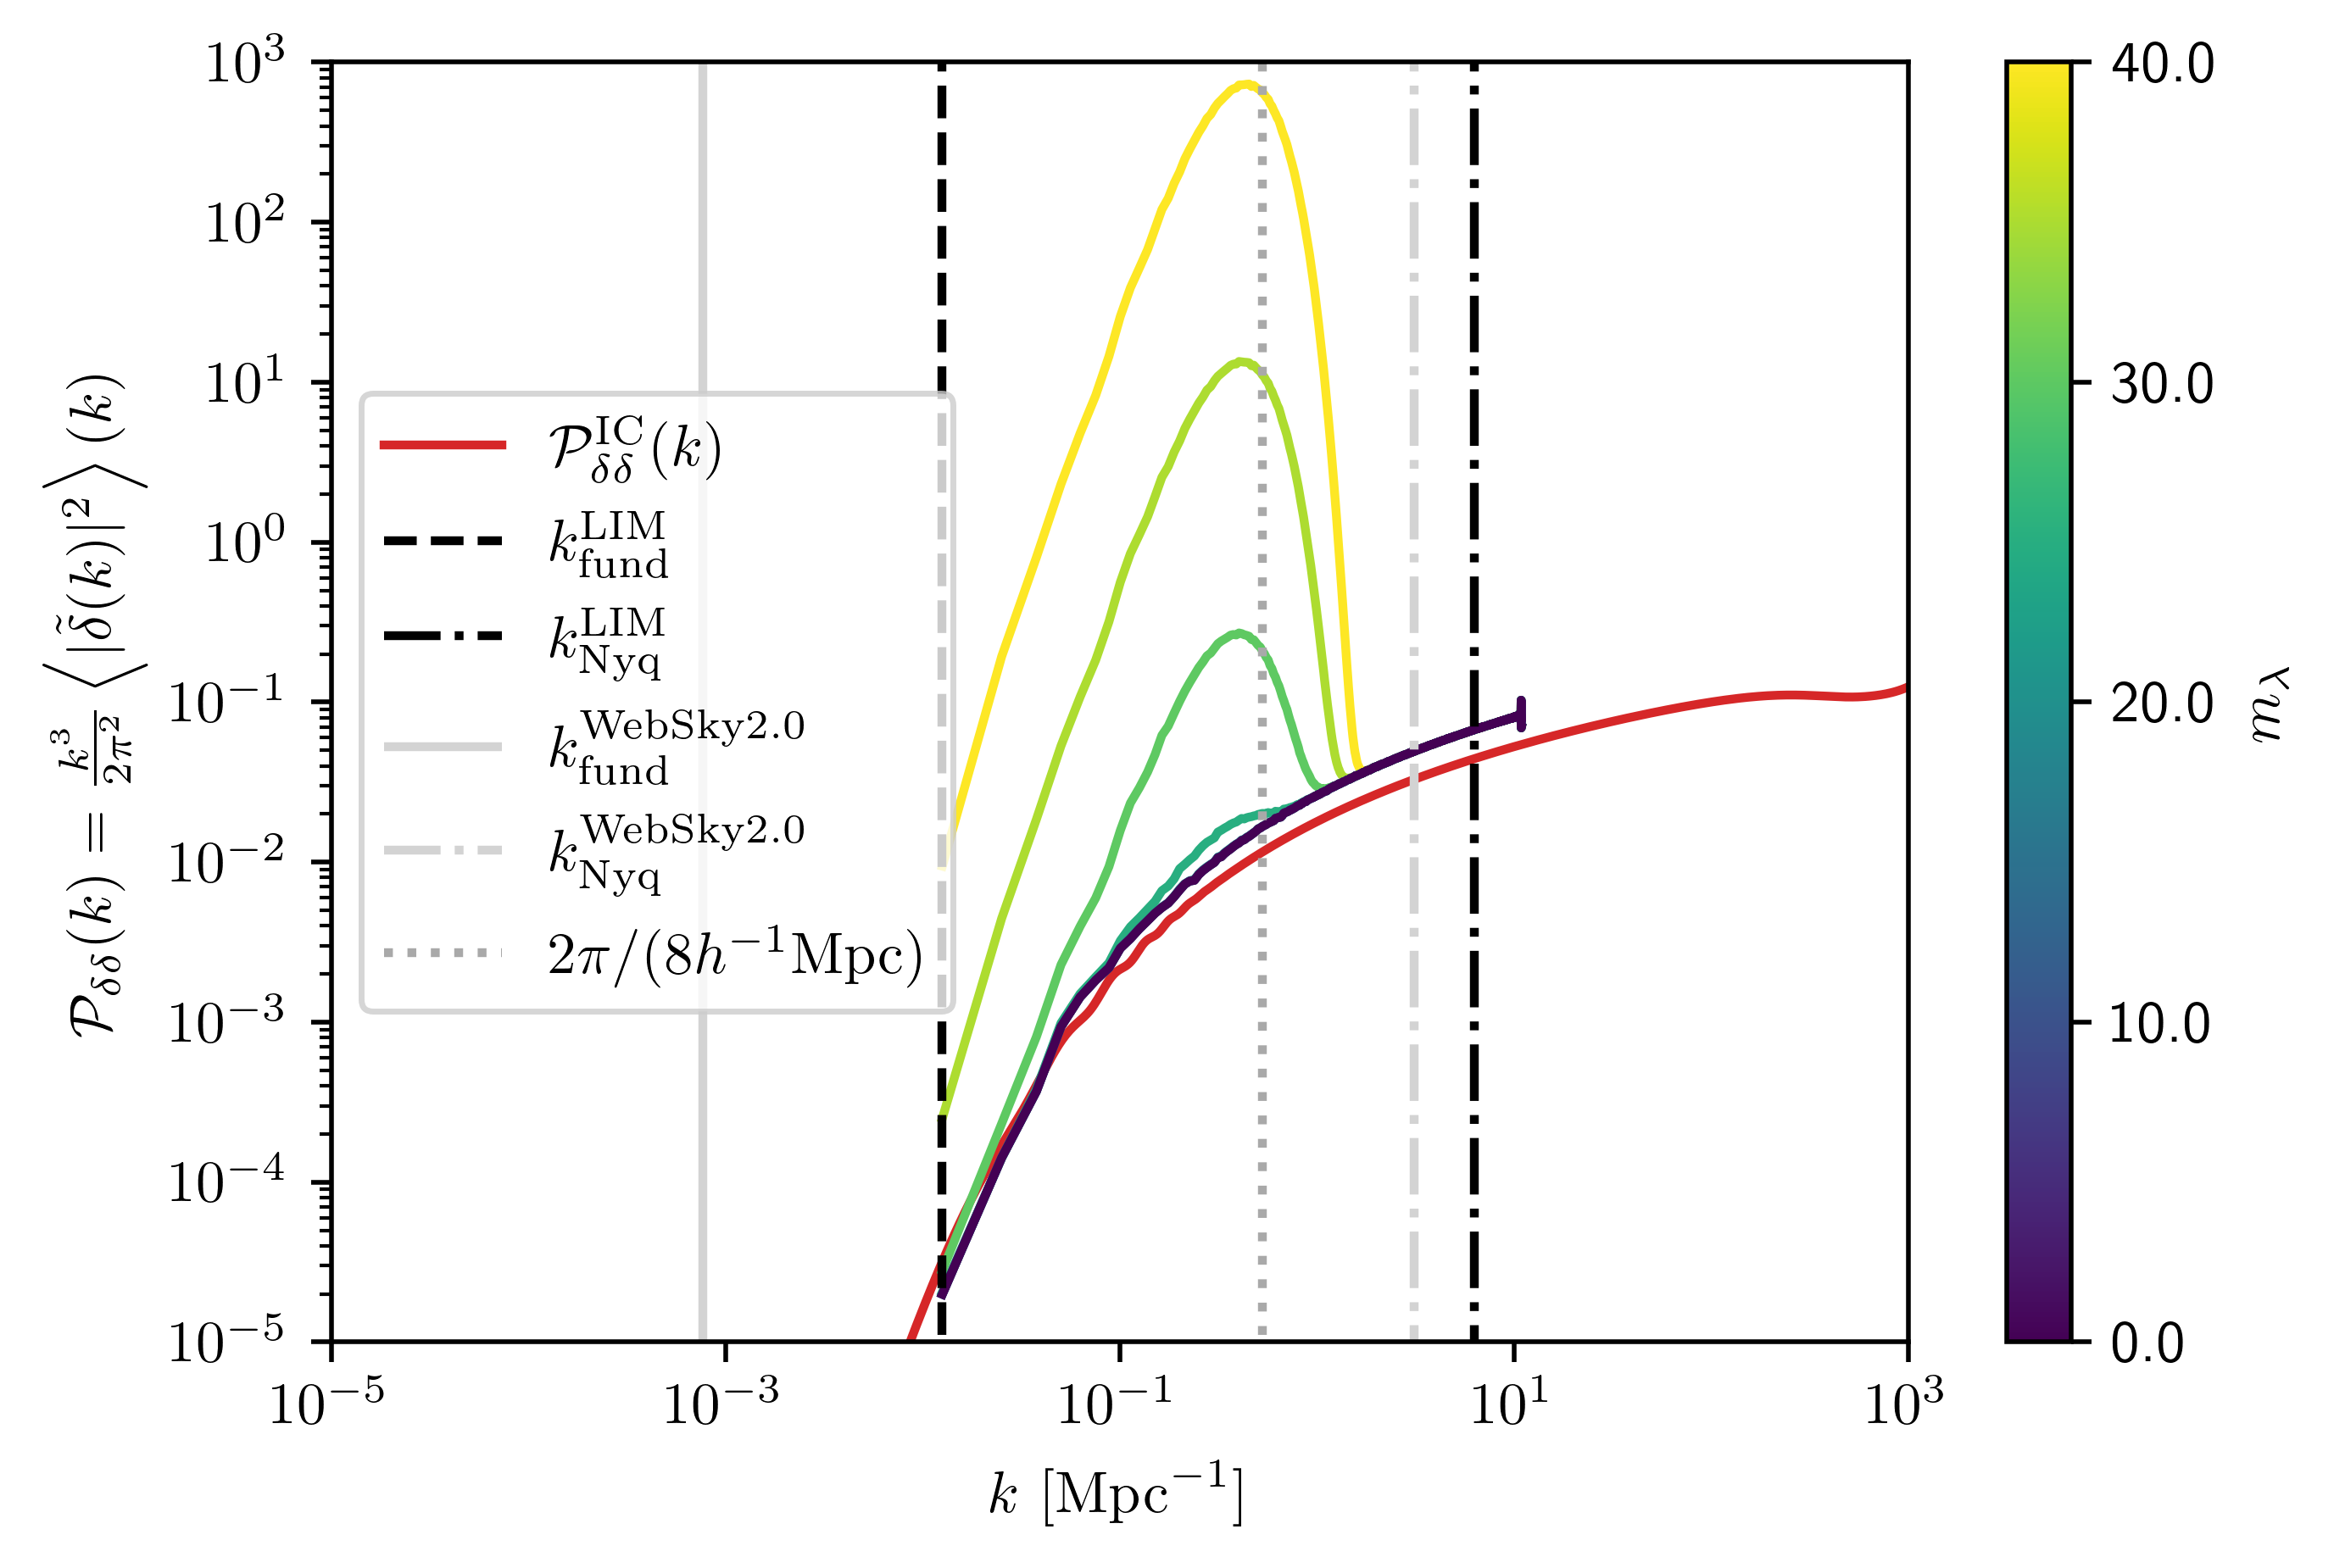

In [31]:
# Define figure to compare power spectra
fig,ax = plt.subplots( dpi=500, facecolor='white' )

# Plot delta_G power spectrum
ax.plot( runs[0].k_deltadelta , runs[0].k_deltadelta**3*runs[0].P_deltadelta/(2*np.pi**2) ,
         label=r'$\mathcal{P}_{\delta\delta}^\mathrm{IC}(k)$',
         c = 'tab:red' )

# Plot rho calculated from files
for j in range(len(runs)-1,0,-1):
    ax.plot( runs[j].k_from_rho, runs[j].p_from_rho * runs[j].k_from_rho**3/(2*np.pi**2) ,
             #label=r'$\mathcal{{P}}_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
              c = plt.cm.viridis( runs[j].m_tach/runs[-1].m_tach )
              )

# Plot rhog calculated from file
ax.plot( runs[0].k_from_rhog, runs[0].p_from_rhog * runs[0].k_from_rhog**3/(2*np.pi**2) ,
         #label=r'$\mathcal{P}_{\delta_g\delta_g}$ from file' )
         c = plt.cm.viridis( 0.0 ) )
    
# Customize the colorbar ticks to match your temperature values
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label=r'$m_\lambda$')
cbar.set_ticks(np.linspace(0, 1., 5))
cbar.set_ticklabels(np.linspace(0, runs[-1].m_tach, 5))

# Vertical lines at fundamental and Nyquist wavenumbers for LIM runs
p_min = np.min(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
p_max = np.max(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
ax.vlines( runs[0].kfund, p_min, p_max, label=r'$k_\mathrm{fund}^\mathrm{LIM}$', color='k', ls='--' )   
ax.vlines( runs[0].knyq , p_min, p_max, label=r'$k_\mathrm{Nyq}^\mathrm{LIM}$'    , color='k', ls='-.' )    

# Vertical lines at fundamental and Nyquist wavenumbers for WebSky2.0
kfund_WS2 = 2*np.pi/(8200)                   # Mpc^{-1}
knyq_WS2  = 2*np.pi/(8200)*((8200-2*40)/2+1) # Mpc^{-1}
ax.vlines( kfund_WS2, p_min, p_max, label= r'$k_\mathrm{fund}^\mathrm{WebSky2.0}$', color='lightgray', ls='-' ) 
ax.vlines( knyq_WS2 , p_min, p_max, label= r'$k_\mathrm{Nyq}^\mathrm{WebSky2.0}$'    , color='lightgray', ls='-.' ) 

# Vertical line at 8 h^-1 Mpc
ksigma8 = 2*np.pi/( 8.0 / runs[0].h )
ax.vlines( ksigma8 , p_min, p_max, label=r'$2\pi/(8h^{-1}\mathrm{Mpc})$', color='darkgray', ls=':' )

# Could add .e.g. more gray lines showing particular scales (galaxy regimes, horizon, etc.)

# Label and scale axes
ax.set_xlabel(r'$k ~ [\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$\mathcal{P}_{\delta\delta}(k) = \frac{k^3}{2\pi^2}\left\langle|\tilde{\delta}(k)|^2\right\rangle(k)$')         
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-5,1e3])
ax.set_ylim([1e-5,1e3])
ax.legend(loc='center left')#, bbox_to_anchor=(1, 0.5))



# Need to resurect old power spectrum reading code so we can see what zeta power looks like
# once we've added the nonG part. I started writing a function in peakpatchtools.py that calls
# my old fortran script. That function is called get_power_spectrum, not fully debugged yet
# I think...



In [11]:
# Make some histograms of halos
for j in range( N_runs_w_halos ):
    runs[j].halo_hist2d

In [ ]:
for j in range( N_runs_w_halos ):
    fig,ax = plt.subplots()

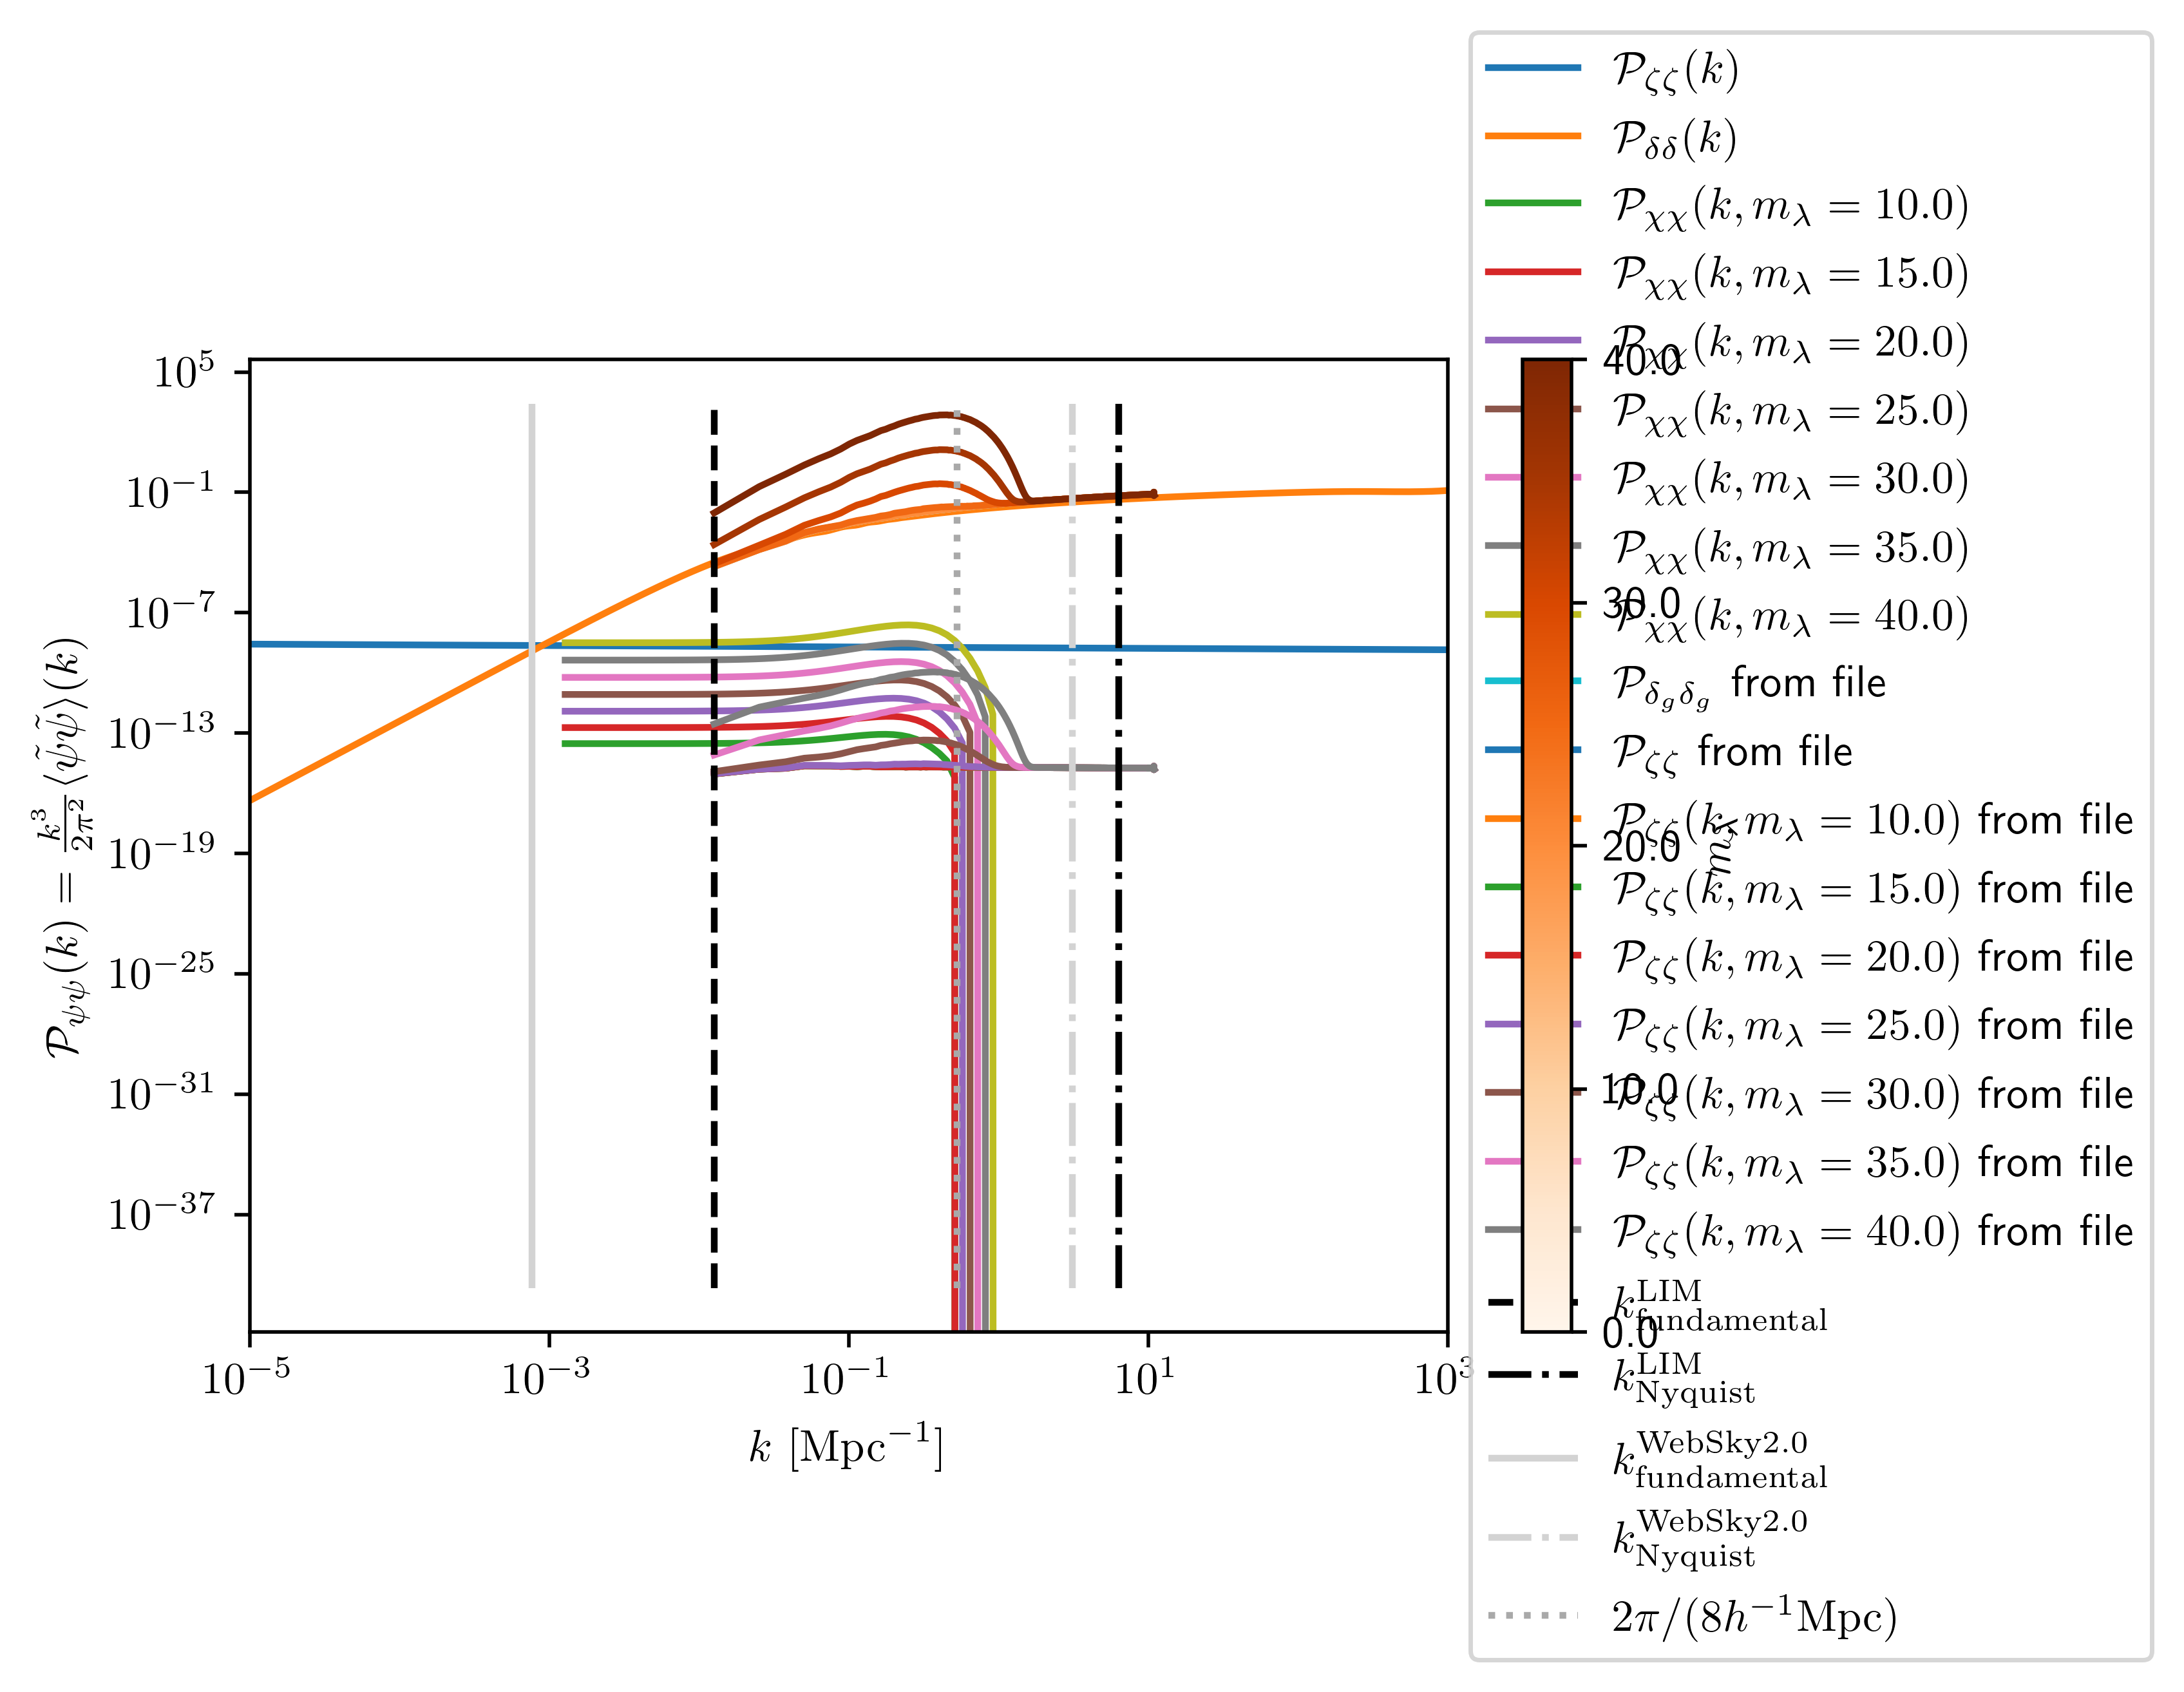

In [32]:
# Define figure to compare power spectra
fig,ax = plt.subplots( dpi=500, facecolor='white' )

# Plot zeta_G power spectrum
ax.plot( runs[0].k_zetazeta , runs[0].k_zetazeta**3*runs[0].P_zetazeta/(2*np.pi**2) ,
         label=r'$\mathcal{P}_{\zeta\zeta}(k)$' )

# Plot delta_G power spectrum
ax.plot( runs[0].k_deltadelta , runs[0].k_deltadelta**3*runs[0].P_deltadelta/(2*np.pi**2) ,
         label=r'$\mathcal{P}_{\delta\delta}(k)$' )

# Plot chi power spectra
for j in range(1,len(runs)):
    ax.plot( runs[j].k_ping , runs[j].p_chichi_ping*runs[j].k_ping**3/(2*np.pi**2) , 
             label=r'$\mathcal{{P}}_{{\chi\chi}}(k,m_\lambda={0})$'.format(runs[j].m_tach))

# Plot rhog calculated from file
ax.plot( runs[0].k_from_rhog, runs[0].p_from_rhog * runs[0].k_from_rhog**3/(2*np.pi**2) ,
        label=r'$\mathcal{P}_{\delta_g\delta_g}$ from file' )

ax.plot( runs[1].k_from_zetag, runs[1].p_from_zetag * runs[1].k_from_zetag**3/(2*np.pi**2) ,
        label=r'$\mathcal{P}_{\zeta\zeta}$ from file')

for j in range(1,len(runs)):
    ax.plot( runs[j].k_from_zeta, runs[j].p_from_zeta * runs[j].k_from_zeta**3/(2*np.pi**2) ,
             label=r'$\mathcal{{P}}_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
    ax.plot( runs[j].k_from_rho, runs[j].p_from_rho * runs[j].k_from_rho**3/(2*np.pi**2) ,
             #label=r'$\mathcal{{P}}_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
              c = plt.cm.Oranges( runs[j].m_tach/runs[-1].m_tach )
              )

# Customize the colorbar ticks to match your temperature values
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Oranges'), label=r'$m_\lambda$')
cbar.set_ticks(np.linspace(0, 1., 5))
cbar.set_ticklabels(np.linspace(0, runs[-1].m_tach, 5))

# Vertical lines at fundamental and Nyquist wavenumbers for LIM runs
p_min = np.min(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
p_max = np.max(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
ax.vlines( runs[0].kfund, p_min, p_max, label=r'$k_\mathrm{fundamental}^\mathrm{LIM}$', color='k', ls='--' )   
ax.vlines( runs[0].knyq , p_min, p_max, label=r'$k_\mathrm{Nyquist}^\mathrm{LIM}$'    , color='k', ls='-.' )    

# Vertical lines at fundamental and Nyquist wavenumbers for WebSky2.0
kfund_WS2 = 2*np.pi/(8200)                   # Mpc^{-1}
knyq_WS2  = 2*np.pi/(8200)*((8200-2*40)/2+1) # Mpc^{-1}
ax.vlines( kfund_WS2, p_min, p_max, label= r'$k_\mathrm{fundamental}^\mathrm{WebSky2.0}$', color='lightgray', ls='-' ) 
ax.vlines( knyq_WS2 , p_min, p_max, label= r'$k_\mathrm{Nyquist}^\mathrm{WebSky2.0}$'    , color='lightgray', ls='-.' ) 

# Vertical line at 8 h^-1 Mpc
ksigma8 = 2*np.pi/( 8.0 / runs[0].h )
ax.vlines( ksigma8 , p_min, p_max, label=r'$2\pi/(8h^{-1}\mathrm{Mpc})$', color='darkgray', ls=':' )

# Could add .e.g. more gray lines showing particular scales (galaxy regimes, horizon, etc.)

# Label and scale axes
ax.set_xlabel(r'$k ~ [\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$\mathcal{P}_{\psi\psi}(k) = \frac{k^3}{2\pi^2}\langle\tilde{\psi}\tilde{\psi}\rangle(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-5,1e3])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Need to resurect old power spectrum reading code so we can see what zeta power looks like
# once we've added the nonG part. I started writing a function in peakpatchtools.py that calls
# my old fortran script. That function is called get_power_spectrum, not fully debugged yet
# I think...



(1e-05, 1000.0)

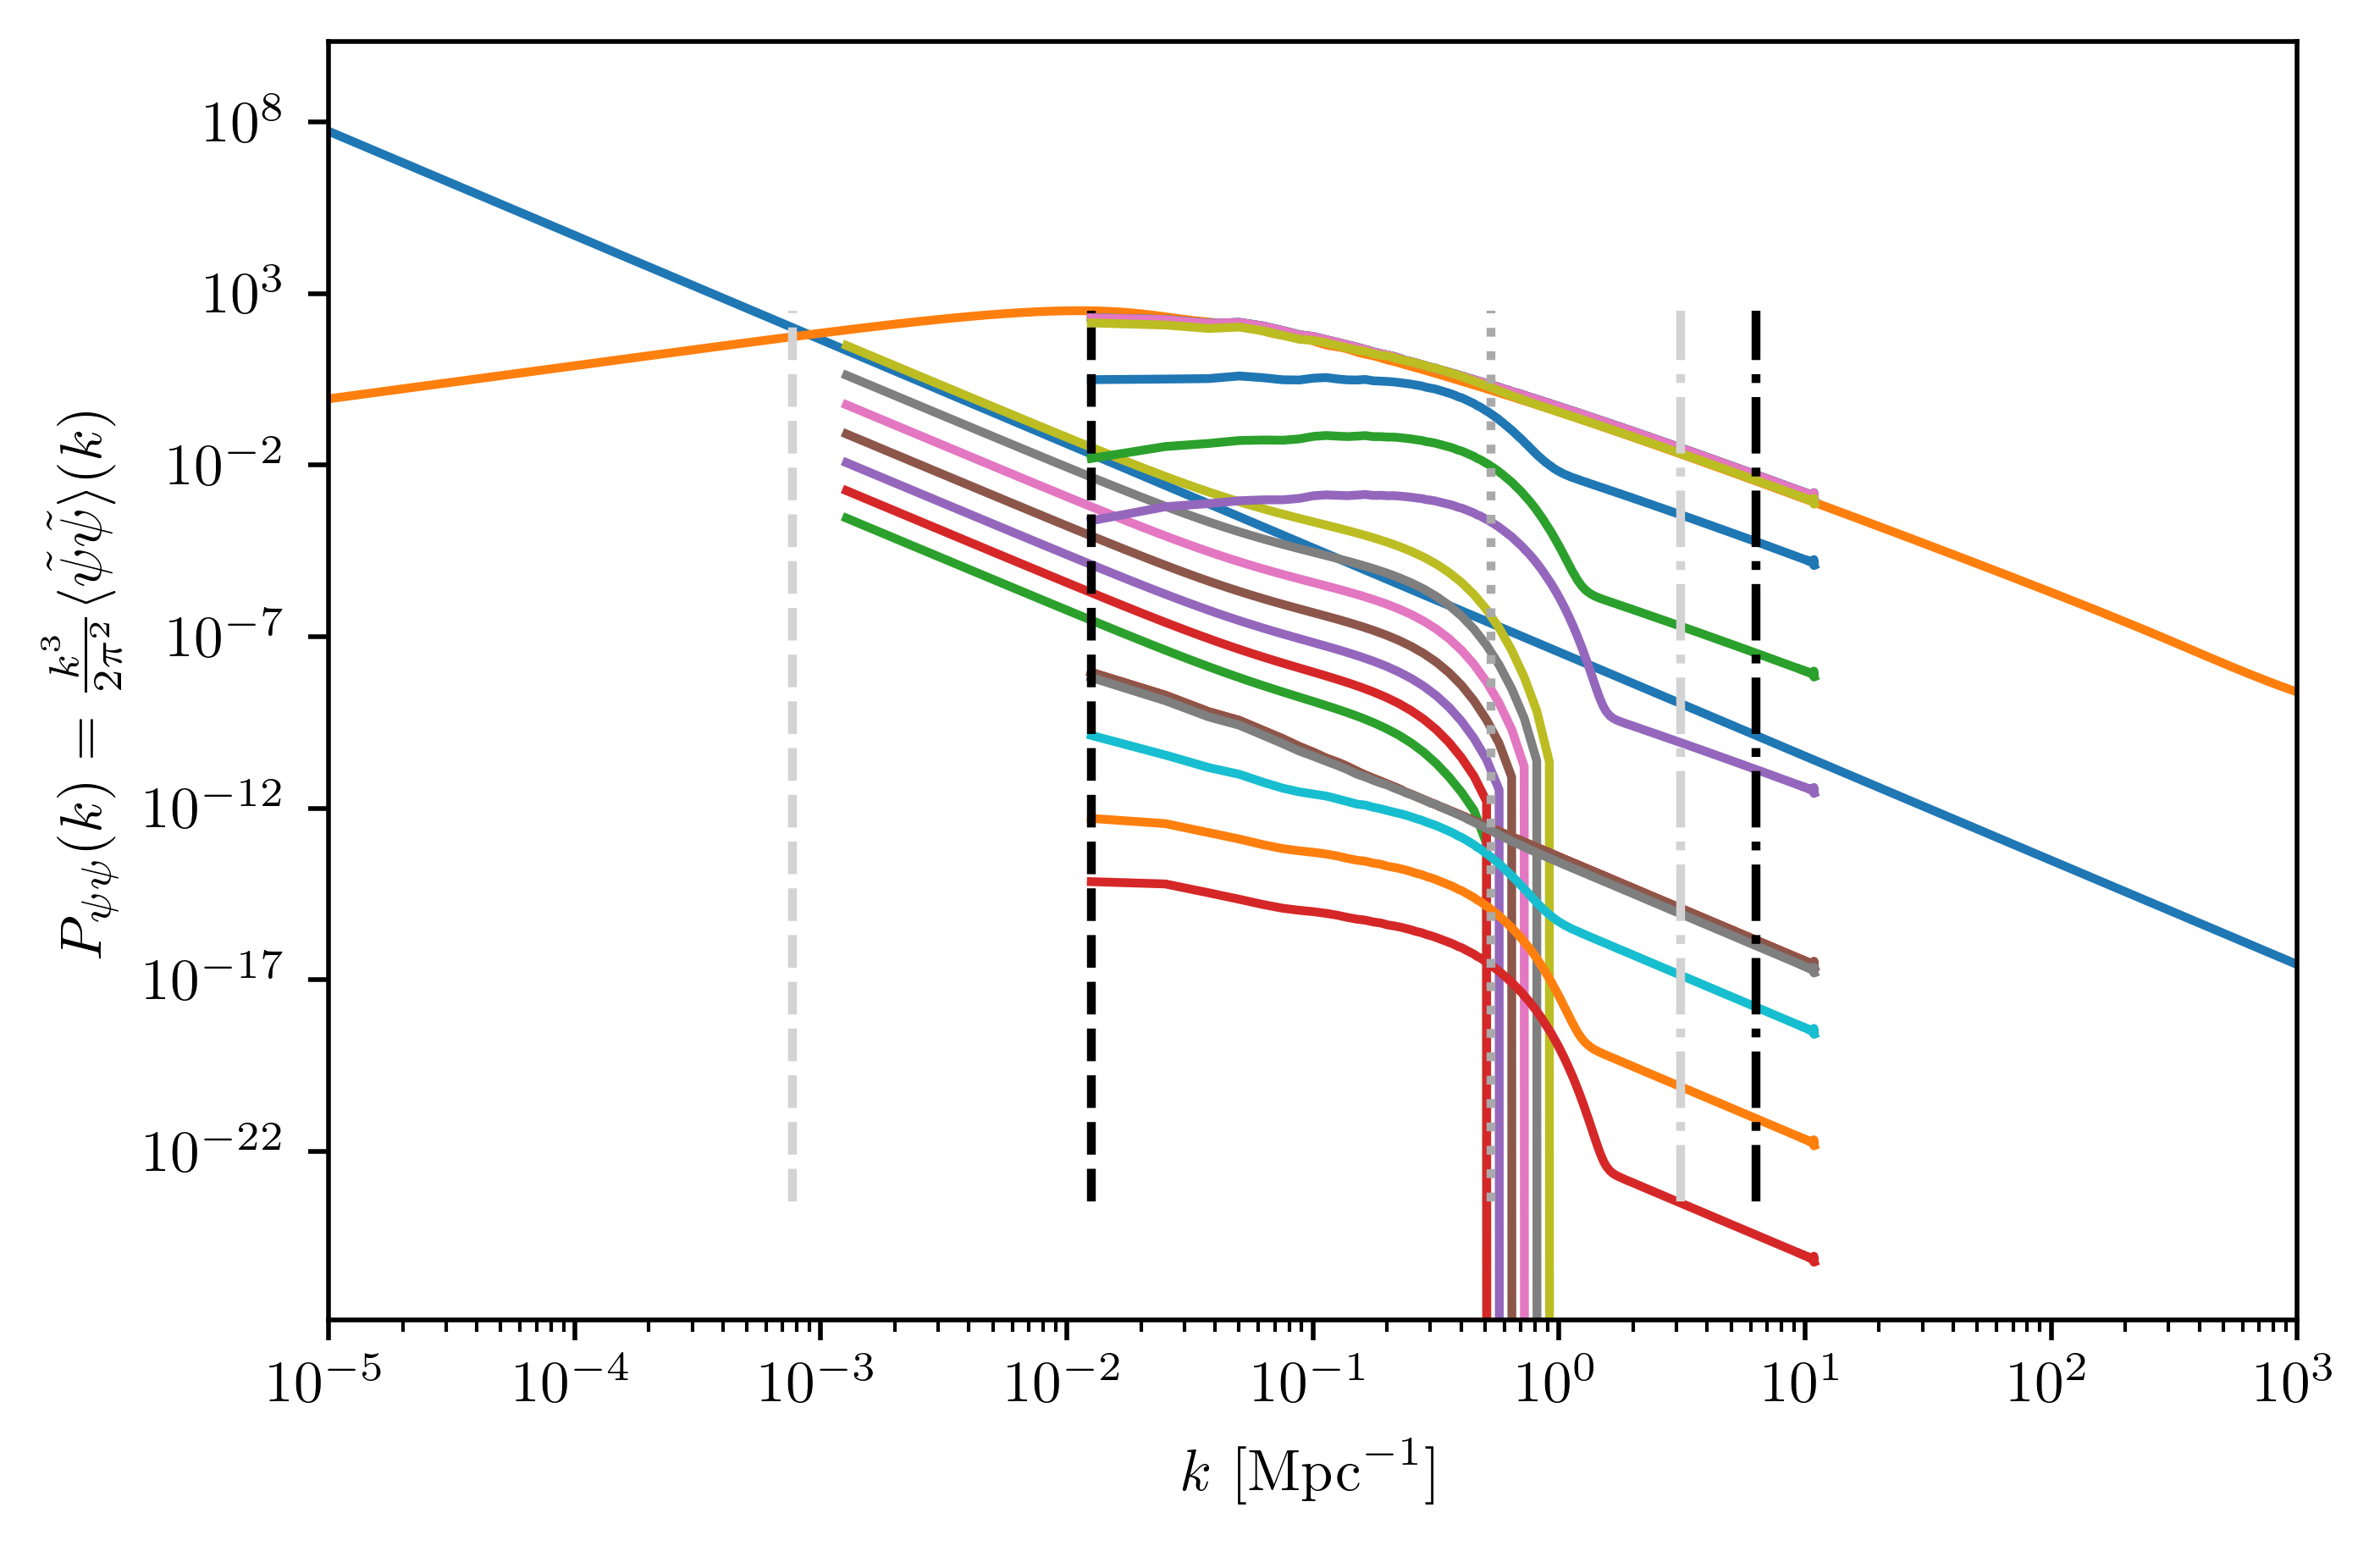

In [20]:
# Define figure to compare power spectra
fig,ax = plt.subplots( dpi=500, facecolor='white' )

# Plot zeta_G power spectrum
ax.plot( runs[0].k_zetazeta , runs[0].P_zetazeta ,
         label=r'$P_{\zeta\zeta}(k)$' )

# Plot delta_G power spectrum
ax.plot( runs[0].k_deltadelta , runs[0].P_deltadelta ,
         label=r'$P_{\delta\delta}(k)$' )

# Plot chi power spectra
for j in range(1,len(runs)):
    ax.plot( runs[j].k_ping , runs[j].p_chichi_ping , 
             label=r'$P_{{\chi\chi}}(k,m_\lambda={0})$'.format(runs[j].m_tach))

# Plot rhog calculated from file
ax.plot( runs[0].k_from_rhog, runs[0].p_from_rhog ,
        label=r'$P_{\delta_g\delta_g}$ from file' )

ax.plot( runs[1].k_from_zetag, runs[1].p_from_zetag ,
        label=r'$P_{\zeta\zeta}$ from file')

for j in range(1,len(runs)):
    ax.plot( runs[j].k_from_zeta, runs[j].p_from_zeta ,
             label=r'$P_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
    ax.plot( runs[j].k_from_rho, runs[j].p_from_rho ,
             label=r'$P_{{\zeta\zeta}}(k,m_\lambda={0})$ from file'.format(runs[j].m_tach))
    
# Vertical lines at fundamental and Nyquist wavenumbers for LIM runs
p_min = np.min(runs[0].P_deltadelta)
p_max = np.max(runs[0].P_deltadelta)
ax.vlines( runs[0].kfund, p_min, p_max, label=r'$k_\mathrm{fundamental}^\mathrm{LIM}$', color='k', ls='--' )   
ax.vlines( runs[0].knyq , p_min, p_max, label=r'$k_\mathrm{Nyquist}^\mathrm{LIM}$'    , color='k', ls='-.' )    

# Vertical lines at fundamental and Nyquist wavenumbers for WebSky2.0
kfund_WS2 = 2*np.pi/(8200)                   # Mpc^{-1}
knyq_WS2  = 2*np.pi/(8200)*((8200-2*40)/2+1) # Mpc^{-1}
ax.vlines( kfund_WS2, p_min, p_max, label= r'$k_\mathrm{fundamental}^\mathrm{WebSky2.0}$', color='lightgray', ls='--' ) 
ax.vlines( knyq_WS2 , p_min, p_max, label= r'$k_\mathrm{Nyquist}^\mathrm{WebSky2.0}$'    , color='lightgray', ls='-.' ) 

# Vertical line at 8 h^-1 Mpc
ksigma8 = 2*np.pi/( 8.0 / runs[0].h )
ax.vlines( ksigma8 , p_min, p_max, label=r'$2\pi/(8h^{-1}\mathrm{Mpc})$', color='darkgray', ls=':' )

# Could add .e.g. more gray lines showing particular scales (galaxy regimes, horizon, etc.)

# Label and scale axes
ax.set_xlabel(r'$k ~ [\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\psi\psi}(k) = \frac{k^3}{2\pi^2}\langle\tilde{\psi}\tilde{\psi}\rangle(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-5,1e3])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Need to resurect old power spectrum reading code so we can see what zeta power looks like
# once we've added the nonG part. I started writing a function in peakpatchtools.py that calls
# my old fortran script. That function is called get_power_spectrum, not fully debugged yet
# I think...



In [15]:
# fig,ax = plt.subplots( dpi=500, facecolor='white' )

# Plot zeta_G power spectrum

kg = runs[0].k_zetazeta
pg = runs[0].k_zetazeta**3*runs[0].P_zetazeta/(2*np.pi**2)
# ax.plot( kg , pg , label=r'$\mathcal{P}_{\zeta\zeta}(k)$' )
pg_mean = np.average(pg)

def prefactor(a,b,c,d,e) :
    return (  (2*np.pi)**(a/2) 
            * (2*np.pi**2)**(b/2)
            * runs[1].boxsize**(c/2)
            * runs[1].neff**(d/2) 
            * runs[1].next**(e/2)   )

k = runs[1].k_from_zetag
p = runs[1].p_from_zetag * runs[1].k_from_zetag**3/(2*np.pi**2)
p_mean = np.average(p)

print('the mean we\'re aiming for is', pg_mean)

b=0
for a in [-6,-3,0,3,6]:
    #for b in range(-6,7):
    for c in [-6,-3,0,3,6]:
        for d in [-6,-3,0,3,6]:
            for e in [-6,-3,0,3,6]:
                pfac = prefactor(a,b,c,d,e)
                P_mean = pfac * p_mean
                if((P_mean<1.1*pg_mean)and(P_mean>0.9*pg_mean)):
                    
                    print( P_mean , a,b,c,d,e )
                    #ax.plot( k, p*pfac, label='a,c,d,e={0},{1},{2},{3}'.format(a,c,d,e) )
             
# # Vertical lines at fundamental and Nyquist wavenumbers for LIM runs
# p_min = np.min(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
# p_max = np.max(runs[0].P_deltadelta*runs[0].k_deltadelta**3/(2*np.pi**2))
# ax.vlines( runs[0].kfund, p_min, p_max, label=r'$k_\mathrm{fundamental}^\mathrm{LIM}$', color='k', ls='--' )   
# ax.vlines( runs[0].knyq , p_min, p_max, label=r'$k_\mathrm{Nyquist}^\mathrm{LIM}$'    , color='k', ls='-.' )    

# # Vertical lines at fundamental and Nyquist wavenumbers for WebSky2.0
# kfund_WS2 = 2*np.pi/(8200)                   # Mpc^{-1}
# knyq_WS2  = 2*np.pi/(8200)*((8200-2*40)/2+1) # Mpc^{-1}
# ax.vlines( kfund_WS2, p_min, p_max, label= r'$k_\mathrm{fundamental}^\mathrm{WebSky2.0}$', color='lightgray', ls='--' ) 
# ax.vlines( knyq_WS2 , p_min, p_max, label= r'$k_\mathrm{Nyquist}^\mathrm{WebSky2.0}$'    , color='lightgray', ls='-.' ) 

# # Label and scale axes
# ax.set_xlabel(r'$k ~ [\mathrm{Mpc}^{-1}]$')
# ax.set_ylabel(r'$\mathcal{P}_{\psi\psi}(k) = \frac{k^3}{2\pi^2}\langle\tilde{\psi}\tilde{\psi}\rangle(k)$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([1e-5,1e3])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

the mean we're aiming for is 1.985087970595385e-09
2.0971906368892664e-09 -6 0 3 3 0
2.0727040915082608e-09 3 0 -3 3 3
1.8344789578339175e-09 6 0 6 0 -3


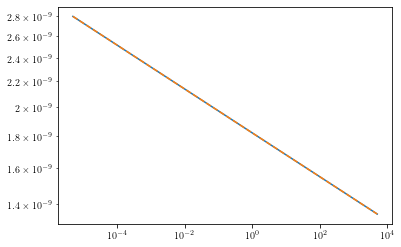

In [12]:
k_deltag = runs[0].k_deltadelta
p_deltag = runs[0].k_deltadelta**3*runs[0].P_deltadelta/(2*np.pi**2)

p_zetag = runs[0].k_zetazeta**3*runs[0].P_zetazeta/(2*np.pi**2)
k_zetag = runs[0].k_zetazeta

k_z2d = runs[0].k_zeta2delta
t_z2d = runs[0].T_zeta2delta 

p_z2d = runs[0].P_deltadelta / runs[0].k_zeta2delta**2 / runs[0].T_zeta2delta**2


fig,ax = plt.subplots()

ax.plot( k_zetag,p_zetag )
ax.plot( k_z2d , k_z2d**3 * p_z2d /(2*np.pi**2) , ls='--')

ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


In [7]:
# Plot some fields
'''
for j in range(1,len(runs)):
    fig,ax = plt.subplots( dpi=500, facecolor='white' )
    runs[j].plot_field_slice(fig,ax,'zeta')
    plt.show()
'''
print( np.max( runs[1].zeta[0] ) )
print('bears')

print( runs[1].NonGauss )
# use plot_field_slice, this will do diffs for you, but not e.g. between runs, so I should
# probably add a plot_field_slice_diff that compares two different PeakPatch class objects
# fields.

# m_tach_25.plot_field_slice(fig,ax,'chi')

# fig.savefig('/cita/d/www/home/njcarlson/figures/23.11.06/Pk_mlambda_sweep.pdf',bbox_inches='tight')



# Check fields for m_lambda > 25 to see what happened, in the first instance, just do a max or
# min to see if you can sus out any NaNs.

# Need to reintegrate my power spectrum reading code into peakpatchtools.py, it would be good
# to not repeat ourselves, so in the default case it could check if it's read one in already
# and only if not (or if told to overwrite) then it would actually make a new one.



AttributeError: 'PeakPatch' object has no attribute 'zeta'

In [ ]:
# Plot some halos

# Halo diffs are the more important thing here...


# Also HMFs and Srel




Let's look at the transform of the modulous square of a function. This means the function times it's complex conjugate:
\begin{align*}
	\mathcal{F}\left[|f(\mathbf{x})|^2\right](\mathbf{k})
	&=
	\int \frac{d^3\mathbf{x}}{(2\pi)^3} |f(\mathbf{x})|^2 e^{i\mathbf{k}\cdot\mathbf{x}}
	\\
	&=
	\int \frac{d^3\mathbf{x}}{(2\pi)^3} f^*(\mathbf{x})f(\mathbf{x}) e^{i\mathbf{k}\cdot\mathbf{x}}
\end{align*}
now let's see what happens when we express $f(\mathbf{x})$ as the inverse Fourier transform of $\tilde{f}(\mathbf{k})$
\begin{align*}
	\mathcal{F}\left[|f(\mathbf{x})|^2\right](\mathbf{k})
	&=
	\int \frac{d^3\mathbf{x}}{(2\pi)^3} 
    \left[ \int d^3\mathbf{k}'  \tilde{f}(\mathbf{k}' ) e^{-i\mathbf{k}' \cdot\mathbf{x}} \right]^*
    \left[ \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') e^{-i\mathbf{k}''\cdot\mathbf{x}} \right]
    e^{i\mathbf{k}\cdot\mathbf{x}}
	\\
	&=
	\int \frac{d^3\mathbf{x}}{(2\pi)^3} 
    \left[ \int d^3\mathbf{k}'  \tilde{f}^*(\mathbf{k}') e^{+i\mathbf{k}' \cdot\mathbf{x}} \right]
    \left[ \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'' ) e^{-i\mathbf{k}''\cdot\mathbf{x}} \right]
    e^{i\mathbf{k}\cdot\mathbf{x}}
    \\
    &=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \int d^3\mathbf{k}' \tilde{f}^*(\mathbf{k}') \int \frac{d^3\mathbf{x}}{(2\pi)^3} 
    e^{ -i ( \mathbf{k}' - \mathbf{k} - \mathbf{k}'' )\cdot\mathbf{x} }
\end{align*}
Here we recognise the Dirac delta function*
\begin{align*}
	\mathcal{F}\left[|f(\mathbf{x})|^2\right](\mathbf{k})
	&=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \int d^3\mathbf{k}' \tilde{f}^*(\mathbf{k}') \tilde{\delta}_D( \mathbf{k}' - \mathbf{k} - \mathbf{k}'' )
    \\
	&=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \tilde{f}^*(\mathbf{k} + \mathbf{k}'')
\end{align*}
or similarly
\begin{align*}
    \mathcal{F}\left[f^2(\mathbf{x})\right](\mathbf{k})
    &=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \tilde{f}(\mathbf{k} - \mathbf{k}'')
\end{align*}
And we arrive at a special case of the convolution theorem where both functions are the same.

If the Fourier transform is equal to a zero-mean, unit-variance white noise field $n_{\sigma=1,\mu=0}(\mathbf{x})$ convolved with the square root of the autocorrelation function $\sqrt{P(k)} \tilde{n}_{\sigma=1,\mu=0}(\mathbf{k})$, so the Fourier transform of the square of the function becomes
\begin{align*}
	\mathcal{F}\left[f^2(\mathbf{x})\right](\mathbf{k})
	&=
    \int d^3\mathbf{k}' \sqrt{P(k')} \tilde{n}_{\sigma=1,\mu=0}(\mathbf{k}') \sqrt{P\left(|\mathbf{k}-\mathbf{k}'|\right)} \tilde{n}_{\sigma=1,\mu=0}(\mathbf{k} - \mathbf{k}')
    \\
    &=
    \int d^3\mathbf{k}' \sqrt{P(k')P\left(|\mathbf{k}-\mathbf{k}'|\right)} \tilde{n}_{\sigma=1,\mu=0}(\mathbf{k}')  \tilde{n}_{\sigma=1,\mu=0}(\mathbf{k} - \mathbf{k}')
\end{align*}
In the current apprimate model we're using, the power $P_{\chi\chi}(k>k_\mathrm{pulse})=0$, so we can freely change the bounds of the integral over $dk'$ from $k'\in(0,\infty)$ to $k'\in(0,k_\mathrm{pulse})$. Then for the second factor of the power $P_{\chi\chi}(|\mathbf{k}-\mathbf{k}'|)$ is zero for $|\mathbf{k}-\mathbf{k}'| > k_\mathrm{pulse}$ or equivalently for $k>2k_\mathrm{pulse}$.

--

*To see this, let's look at the Fourier transform of its inverse
\begin{equation*}
	\begin{split}
		f(x) &= \mathcal{F}^{-1}\left[ \tilde{f}(k) \right](x)
		\\
		&= \int_{-\infty}^\infty \left( \frac{1}{2\pi} \int_{-\infty}^\infty f(x') e^{ikx'} dx' \right)e^{-ikx} dk
		\\
		&= \int_{-\infty}^\infty dx' f(x') \int_{-\infty}^\infty \frac{dk}{2\pi} e^{ik(x'-x)}
	\end{split}
	\qquad
	\begin{split}
		\tilde{f}(k) &= \mathcal{F}\left[ f(x) \right](k)
		\\
		&= \frac{1}{2\pi} \int_{-\infty}^\infty \left( \int_{-\infty}^\infty \tilde{f}(k') e^{-ik'x} dk' \right) e^{ikx} dx
		\\
		&= \int_{-\infty}^\infty dk' \tilde{f}(k') \int_{-\infty}^\infty \frac{dx}{2\pi} e^{-i(k'-k)x}
	\end{split}
\end{equation*}
The last line in each is true if $\int_{-\infty}^\infty e^{ik(x'-x)} dk/2\pi = \delta_D(x'-x)$ and $\int_{-\infty}^\infty e^{-i(k'-k)x} dx/2\pi = \tilde{\delta}_D(k'-k)$.

\begin{align*}
	\mathcal{F}\left[|f(\mathbf{x})|^2\right](\mathbf{k})
	&=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \int d^3\mathbf{k}' \tilde{f}^*(\mathbf{k}') \int \frac{d^3\mathbf{x}}{(2\pi)^3} 
    e^{ -i ( \mathbf{k}' - \mathbf{k} - \mathbf{k}'' )\cdot\mathbf{x} }
	\\
	&=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \int d^3\mathbf{k}' \tilde{f}^*(\mathbf{k}') \tilde{\delta}_D( \mathbf{k}' - \mathbf{k} - \mathbf{k}'' )
    \\
	&=
    \int d^3\mathbf{k}'' \tilde{f}(\mathbf{k}'') \tilde{f}^*(\mathbf{k} + \mathbf{k}'')
\end{align*}